In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

# Enable cuDNN Benchmarking for performance
cudnn.benchmark = True

# ---------------------------
# 1. Data Directories & Helper Function
# ---------------------------
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir, val_dir, test_dir = [os.path.join(data_dir, x) for x in ["train", "val", "test"]]

def get_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(root_dir))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(label)
    return image_paths, labels, class_names

train_images, train_labels, classes = get_image_paths_and_labels(train_dir)
val_images, val_labels, _ = get_image_paths_and_labels(val_dir)
test_images, test_labels, _ = get_image_paths_and_labels(test_dir)

# ---------------------------
# 2. Data Augmentation (Optimized)
# ---------------------------
IMG_SIZE = 380

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.GridDistortion(p=0.3),
    A.CLAHE(p=0.2),
    A.CoarseDropout(max_holes=1, max_height=30, max_width=30, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# ---------------------------
# 3. Custom Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        image = self.transform(image=image)["image"]
        return image, label

# ---------------------------
# 4. Weighted Sampler for Class Imbalance
# ---------------------------
def get_weighted_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    weights = [class_weights[label] for label in labels]
    return WeightedRandomSampler(weights, len(weights), replacement=True)

# ---------------------------
# 5. Model Definition (Fine-tuned)
# ---------------------------
def get_model(num_classes):
    model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

# ---------------------------
# 6. Loss Function & Optimizer
# ---------------------------
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.05):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, preds, targets):
        n_classes = preds.size(1)
        targets = F.one_hot(targets, n_classes).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / n_classes
        return F.cross_entropy(preds, targets)

def get_optimizer(model):
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=70)
    return optimizer, scheduler

# ---------------------------
# 7. Training Function
# ---------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=70, patience=10):
    scaler = torch.cuda.amp.GradScaler()
    history = {"train_loss": [], "val_acc": []}
    best_acc, counter = 0, 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        val_acc = evaluate_model(model, val_loader, show_cm=False)
        history["train_loss"].append(running_loss / total)
        history["val_acc"].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/kaggle/working/best_model2.pth")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/total:.4f}, Val Acc: {val_acc:.2f}%")

    return model, history

# ---------------------------
# 8. Evaluation Function (Confusion Matrix at End)
# ---------------------------
def evaluate_model(model, loader, show_cm=True):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    return 100 * np.mean(np.array(all_preds) == np.array(all_labels))

# ---------------------------
# 9. Main Execution
# ---------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader = DataLoader(CustomDataset(train_images, train_labels, train_transform), batch_size=16, sampler=get_weighted_sampler(train_labels), num_workers=2)
    val_loader = DataLoader(CustomDataset(val_images, val_labels, test_transform), batch_size=16, shuffle=False, num_workers=2)

    model = get_model(len(classes))
    model, history = train_model(model, train_loader, val_loader, LabelSmoothingLoss(), *get_optimizer(model), num_epochs=70)

    print("\nFinal Evaluation on Validation Set:")
    evaluate_model(model, val_loader, show_cm=True)

    # Plot Training Loss and Validation Accuracy
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history["val_acc"], label="Validation Accuracy", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()

    plt.show()

    # Final Confusion Matrix
    print("\nFinal Evaluation on Validation Set:")
    evaluate_model(model, val_loader, show_cm=True)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 81.2MB/s]
<ipython-input-1-c8422cf7a016>:136: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/379 [00:00<?, ?it/s]<ipython-input-1-c8422cf7a016>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 379/379 [0

Epoch [1/70], Train Loss: 0.7346, Val Acc: 86.86%


100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


KeyboardInterrupt: 

<ipython-input-3-c49c991c8d59>:140: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/70:   0%|          | 0/379 [00:00<?, ?it/s]<ipython-input-3-c49c991c8d59>:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/70: 100%|██████████| 379/379 [02:04<00:00,  3.04it/s]


Epoch [1/70], Train Loss: 0.7259, Val Acc: 87.60%


Epoch 2/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [2/70], Train Loss: 0.5739, Val Acc: 87.85%


Epoch 3/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [3/70], Train Loss: 0.5392, Val Acc: 85.81%


Epoch 4/70: 100%|██████████| 379/379 [02:03<00:00,  3.06it/s]


Epoch [4/70], Train Loss: 0.5048, Val Acc: 90.03%


Epoch 5/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [5/70], Train Loss: 0.4983, Val Acc: 86.51%


Epoch 6/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [6/70], Train Loss: 0.4771, Val Acc: 86.90%


Epoch 7/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [7/70], Train Loss: 0.4809, Val Acc: 90.23%


Epoch 8/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [8/70], Train Loss: 0.4563, Val Acc: 92.06%


Epoch 9/70: 100%|██████████| 379/379 [02:03<00:00,  3.06it/s]


Epoch [9/70], Train Loss: 0.4335, Val Acc: 92.16%


Epoch 10/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [10/70], Train Loss: 0.4251, Val Acc: 91.96%


Epoch 11/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [11/70], Train Loss: 0.4259, Val Acc: 90.87%


Epoch 12/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [12/70], Train Loss: 0.4011, Val Acc: 91.42%


Epoch 13/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [13/70], Train Loss: 0.3944, Val Acc: 91.17%


Epoch 14/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [14/70], Train Loss: 0.3872, Val Acc: 91.02%


Epoch 15/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [15/70], Train Loss: 0.3898, Val Acc: 91.82%


Epoch 16/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Epoch [16/70], Train Loss: 0.3736, Val Acc: 92.31%


Epoch 17/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Epoch [17/70], Train Loss: 0.3696, Val Acc: 91.87%


Epoch 18/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [18/70], Train Loss: 0.3667, Val Acc: 92.66%


Epoch 19/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [19/70], Train Loss: 0.3552, Val Acc: 93.06%


Epoch 20/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Epoch [20/70], Train Loss: 0.3475, Val Acc: 92.46%


Epoch 21/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [21/70], Train Loss: 0.3479, Val Acc: 92.26%


Epoch 22/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [22/70], Train Loss: 0.3399, Val Acc: 93.85%


Epoch 23/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [23/70], Train Loss: 0.3326, Val Acc: 93.01%


Epoch 24/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Epoch [24/70], Train Loss: 0.3239, Val Acc: 92.21%


Epoch 25/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Epoch [25/70], Train Loss: 0.3181, Val Acc: 93.11%


Epoch 26/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Epoch [26/70], Train Loss: 0.3119, Val Acc: 92.61%


Epoch 27/70: 100%|██████████| 379/379 [02:03<00:00,  3.07it/s]


Epoch [27/70], Train Loss: 0.3108, Val Acc: 92.91%


Epoch 28/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [28/70], Train Loss: 0.3063, Val Acc: 92.86%


Epoch 29/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Epoch [29/70], Train Loss: 0.2966, Val Acc: 93.15%


Epoch 30/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Epoch [30/70], Train Loss: 0.2916, Val Acc: 92.36%


Epoch 31/70: 100%|██████████| 379/379 [02:03<00:00,  3.08it/s]


Epoch [31/70], Train Loss: 0.2949, Val Acc: 93.55%


Epoch 32/70: 100%|██████████| 379/379 [02:02<00:00,  3.09it/s]


Early stopping triggered!

Final Evaluation on Validation Set:


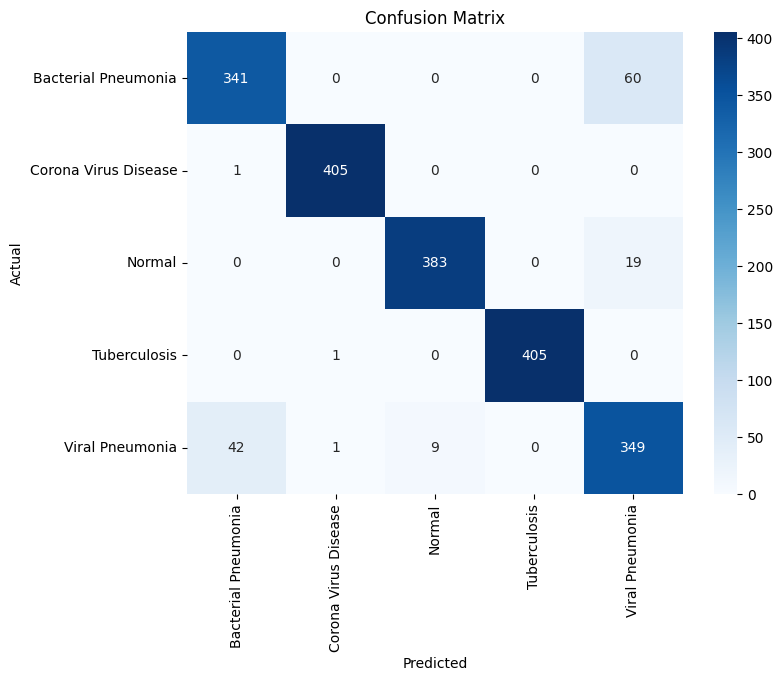

Final Validation Accuracy: 93.40%


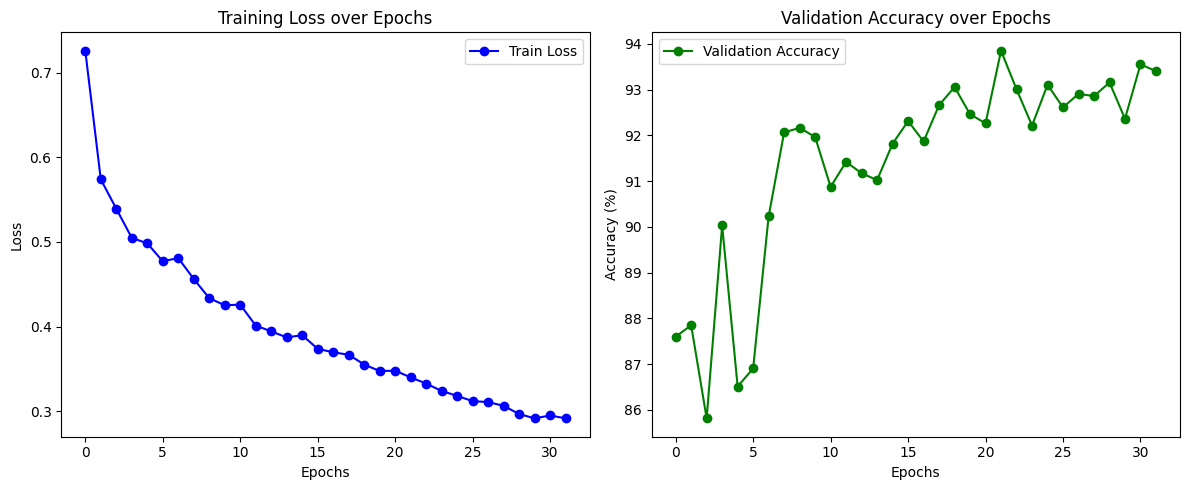

In [3]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

# Enable cuDNN Benchmarking for performance
cudnn.benchmark = True

# Define device at the start
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1. Data Directories & Helper Function
# ---------------------------
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir, val_dir, test_dir = [os.path.join(data_dir, x) for x in ["train", "val", "test"]]

def get_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(root_dir))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(label)
    return image_paths, labels, class_names

train_images, train_labels, classes = get_image_paths_and_labels(train_dir)
val_images, val_labels, _ = get_image_paths_and_labels(val_dir)
test_images, test_labels, _ = get_image_paths_and_labels(test_dir)

# ---------------------------
# 2. Data Augmentation (Optimized)
# ---------------------------
IMG_SIZE = 380

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.GridDistortion(p=0.3),
    A.CLAHE(p=0.2),
    A.CoarseDropout(max_holes=1, max_height=30, max_width=30, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# ---------------------------
# 3. Custom Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        image = self.transform(image=image)["image"]
        return image, label

# ---------------------------
# 4. Weighted Sampler for Class Imbalance
# ---------------------------
def get_weighted_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / np.maximum(class_counts, 1)  # Prevent division by zero
    weights = [class_weights[label] for label in labels]
    return WeightedRandomSampler(weights, len(weights), replacement=True)

# ---------------------------
# 5. Model Definition (Fine-tuned)
# ---------------------------
def get_model(num_classes):
    model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features  # Correct way to access in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

# ---------------------------
# 6. Loss Function & Optimizer
# ---------------------------
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.05):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, preds, targets):
        n_classes = preds.size(1)
        log_preds = F.log_softmax(preds, dim=-1)
        targets = F.one_hot(targets, n_classes).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / n_classes
        return torch.mean(torch.sum(-targets * log_preds, dim=-1))

def get_optimizer(model, num_epochs=70):
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    return optimizer, scheduler

# ---------------------------
# 7. Training Function
# ---------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=70, patience=10):
    scaler = torch.cuda.amp.GradScaler()
    history = {"train_loss": [], "val_acc": []}
    best_acc, counter = 0, 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        val_acc = evaluate_model(model, val_loader, show_cm=False)
        history["train_loss"].append(running_loss / total)
        history["val_acc"].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/kaggle/working/best_model3.pth")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/total:.4f}, Val Acc: {val_acc:.2f}%")

    return model, history

# ---------------------------
# 8. Evaluation Function
# ---------------------------
def evaluate_model(model, loader, show_cm=True):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    
    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    return accuracy

# ---------------------------
# 9. Main Execution & Plotting
# ---------------------------
if __name__ == "__main__":
    # Create DataLoaders
    train_loader = DataLoader(
        CustomDataset(train_images, train_labels, train_transform),
        batch_size=16,
        sampler=get_weighted_sampler(train_labels),
        num_workers=2
    )
    val_loader = DataLoader(
        CustomDataset(val_images, val_labels, test_transform),
        batch_size=16,
        shuffle=False,
        num_workers=2
    )

    # Get the model and optimizer
    model = get_model(len(classes))
    optimizer, scheduler = get_optimizer(model, num_epochs=70)
    
    # Train the model
    model, history = train_model(
        model, train_loader, val_loader,
        LabelSmoothingLoss(),
        optimizer, scheduler,
        num_epochs=70
    )

    # Final evaluation on the validation set with confusion matrix
    print("\nFinal Evaluation on Validation Set:")
    final_acc = evaluate_model(model, val_loader, show_cm=True)
    print(f"Final Validation Accuracy: {final_acc:.2f}%")
    
    # Plot Training Loss and Validation Accuracy
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss", color="blue", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history["val_acc"], label="Validation Accuracy", color="green", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


# **final code above 93 %**

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.transforms as T

# Enable cuDNN Benchmarking for performance
cudnn.benchmark = True

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1. Data Directories & Helper Function
# ---------------------------
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir, val_dir, test_dir = [os.path.join(data_dir, x) for x in ["train", "val", "test"]]

def get_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(root_dir))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(label)
    return image_paths, labels, class_names

train_images, train_labels, classes = get_image_paths_and_labels(train_dir)
val_images, val_labels, _ = get_image_paths_and_labels(val_dir)

# ---------------------------
# 2. Data Augmentation (Enhanced)
# ---------------------------
IMG_SIZE = 384

# Torchvision transforms for AutoAugment and RandomErasing
autoaugment = T.AutoAugment(T.AutoAugmentPolicy.IMAGENET)
random_erasing = T.RandomErasing(p=0.3, scale=(0.02, 0.3), ratio=(0.3, 3.3), value='random')

def apply_torchvision_transforms(image, **kwargs):  
    """
    Converts the numpy image to PIL, applies AutoAugment and RandomErasing,
    then converts it back to a numpy array.
    """
    pil_img = T.ToPILImage()(image)
    aug_img = autoaugment(pil_img)
    tensor_img = T.ToTensor()(aug_img)
    tensor_img = random_erasing(tensor_img)
    final_img = np.array(T.ToPILImage()(tensor_img))
    return final_img


# Define Albumentations transforms
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Lambda(image=apply_torchvision_transforms),  # Apply Torchvision AutoAugment & RandomErasing
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=40, p=0.6),
    A.RandomBrightnessContrast(p=0.6),
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.7, 1.0)),
    A.CoarseDropout(max_holes=1, max_height=50, max_width=50, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# ---------------------------
# 3. Custom Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        image = self.transform(image=image)["image"]
        return image, label

# ---------------------------
# 4. Weighted Sampler for Class Imbalance
# ---------------------------
def get_weighted_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / np.maximum(class_counts, 1)
    weights = [class_weights[label] for label in labels]
    return WeightedRandomSampler(weights, len(weights), replacement=True)

# ---------------------------
# 5. EfficientNetV2 Model
# ---------------------------
def get_model(num_classes):
    model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features  
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

# ---------------------------
# 6. Loss Function & Optimizer
# ---------------------------
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, preds, targets):
        n_classes = preds.size(1)
        log_preds = F.log_softmax(preds, dim=-1)
        targets = F.one_hot(targets, n_classes).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / n_classes
        return torch.mean(torch.sum(-targets * log_preds, dim=-1))

def get_optimizer(model, num_epochs=70):
    optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    return optimizer, scheduler

# ---------------------------
# 7. Training Function
# ---------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=70):
    history = {"train_loss": [], "val_acc": []}
    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        val_acc = evaluate_model(model, val_loader, show_cm=False)
        history["train_loss"].append(running_loss / total)
        history["val_acc"].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch {epoch+1}: Train Loss: {running_loss/total:.4f}, Val Acc: {val_acc:.2f}%")

    return model, history

# ---------------------------
# 8. Evaluation Function
# ---------------------------
def evaluate_model(model, loader, show_cm=True):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    # Plot Confusion Matrix if desired
    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    return accuracy

# ---------------------------
# 9. Main Execution & Plotting
# ---------------------------
if __name__ == "__main__":
    # Create DataLoaders
    train_loader = DataLoader(
        CustomDataset(train_images, train_labels, train_transform),
        batch_size=32,
        sampler=get_weighted_sampler(train_labels),
        num_workers=2
    )
    val_loader = DataLoader(
        CustomDataset(val_images, val_labels, test_transform),
        batch_size=32,
        shuffle=False,
        num_workers=2
    )

    # Get the model and optimizer
    model = get_model(len(classes))
    optimizer, scheduler = get_optimizer(model, num_epochs=70)

    # Train the model
    model, history = train_model(
        model, train_loader, val_loader,
        LabelSmoothingLoss(), optimizer, scheduler, num_epochs=70
    )

    # Final evaluation on the validation set with confusion matrix
    print("\nFinal Evaluation on Validation Set:")
    final_acc = evaluate_model(model, val_loader, show_cm=True)
    print(f"Final Validation Accuracy: {final_acc:.2f}%")

    # Plot Training Loss and Validation Accuracy over epochs
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], marker='o', color="blue", label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["val_acc"], marker='o', color="green", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 1: Train Loss: 0.9669, Val Acc: 84.82%


Epoch 2/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 2: Train Loss: 0.7642, Val Acc: 86.61%


Epoch 3/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 3: Train Loss: 0.7107, Val Acc: 87.65%


Epoch 4/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 4: Train Loss: 0.6807, Val Acc: 87.10%


Epoch 5/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 5: Train Loss: 0.6635, Val Acc: 88.29%


Epoch 6/70: 100%|██████████| 190/190 [03:04<00:00,  1.03it/s]


Epoch 6: Train Loss: 0.6466, Val Acc: 89.53%


Epoch 7/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 7: Train Loss: 0.6338, Val Acc: 89.98%


Epoch 8/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 8: Train Loss: 0.6296, Val Acc: 90.28%


Epoch 9/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 9: Train Loss: 0.6160, Val Acc: 90.43%


Epoch 10/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 10: Train Loss: 0.6124, Val Acc: 90.72%


Epoch 11/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 11: Train Loss: 0.5915, Val Acc: 89.14%


Epoch 13/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 13: Train Loss: 0.5970, Val Acc: 91.27%


Epoch 14/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 14: Train Loss: 0.5891, Val Acc: 91.27%


Epoch 15/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 15: Train Loss: 0.5820, Val Acc: 91.07%


Epoch 16/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 16: Train Loss: 0.5733, Val Acc: 91.72%


Epoch 17/70: 100%|██████████| 190/190 [03:02<00:00,  1.04it/s]


Epoch 17: Train Loss: 0.5728, Val Acc: 90.72%


Epoch 18/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 18: Train Loss: 0.5719, Val Acc: 90.82%


Epoch 19/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 19: Train Loss: 0.5493, Val Acc: 91.42%


Epoch 20/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 20: Train Loss: 0.5491, Val Acc: 90.13%


Epoch 21/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 21: Train Loss: 0.5414, Val Acc: 88.74%


Epoch 22/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 22: Train Loss: 0.5449, Val Acc: 91.57%


Epoch 23/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 23: Train Loss: 0.5523, Val Acc: 91.77%


Epoch 27/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 27: Train Loss: 0.5097, Val Acc: 91.91%


Epoch 28/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 28: Train Loss: 0.5105, Val Acc: 92.56%


Epoch 29/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 29: Train Loss: 0.5072, Val Acc: 92.06%


Epoch 30/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 30: Train Loss: 0.4974, Val Acc: 92.61%


Epoch 31/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 31: Train Loss: 0.4940, Val Acc: 92.91%


Epoch 32/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 32: Train Loss: 0.4847, Val Acc: 90.62%


Epoch 33/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 33: Train Loss: 0.4901, Val Acc: 93.30%


Epoch 34/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 34: Train Loss: 0.4861, Val Acc: 92.86%


Epoch 35/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 35: Train Loss: 0.4775, Val Acc: 92.66%


Epoch 36/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 36: Train Loss: 0.4777, Val Acc: 92.86%


Epoch 37/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 37: Train Loss: 0.4668, Val Acc: 92.51%


Epoch 38/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 38: Train Loss: 0.4675, Val Acc: 92.91%


Epoch 39/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 39: Train Loss: 0.4632, Val Acc: 93.30%


Epoch 40/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 40: Train Loss: 0.4688, Val Acc: 92.66%


Epoch 41/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 41: Train Loss: 0.4596, Val Acc: 93.15%


Epoch 42/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 42: Train Loss: 0.4472, Val Acc: 93.55%


Epoch 43/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 43: Train Loss: 0.4530, Val Acc: 94.00%


Epoch 44/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 44: Train Loss: 0.4480, Val Acc: 93.65%


Epoch 45/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 45: Train Loss: 0.4416, Val Acc: 93.65%


Epoch 46/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 46: Train Loss: 0.4458, Val Acc: 93.65%


Epoch 47/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 47: Train Loss: 0.4402, Val Acc: 94.10%


Epoch 48/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 48: Train Loss: 0.4399, Val Acc: 93.01%


Epoch 49/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 49: Train Loss: 0.4384, Val Acc: 94.44%


Epoch 50/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 50: Train Loss: 0.4371, Val Acc: 93.60%


Epoch 51/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 51: Train Loss: 0.4314, Val Acc: 93.95%


Epoch 52/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 52: Train Loss: 0.4352, Val Acc: 94.10%


Epoch 53/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 53: Train Loss: 0.4294, Val Acc: 93.95%


Epoch 54/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 54: Train Loss: 0.4273, Val Acc: 94.59%


Epoch 55/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 55: Train Loss: 0.4247, Val Acc: 94.35%


Epoch 56/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 56: Train Loss: 0.4299, Val Acc: 94.39%


Epoch 57/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 57: Train Loss: 0.4278, Val Acc: 94.35%


Epoch 58/70: 100%|██████████| 190/190 [03:03<00:00,  1.04it/s]


Epoch 58: Train Loss: 0.4252, Val Acc: 94.49%


Epoch 59/70: 100%|██████████| 190/190 [03:03<00:00,  1.03it/s]


Epoch 59: Train Loss: 0.4263, Val Acc: 94.49%


Epoch 60/70:  29%|██▉       | 55/190 [00:53<02:10,  1.03it/s]


Final Evaluation on Validation Set:


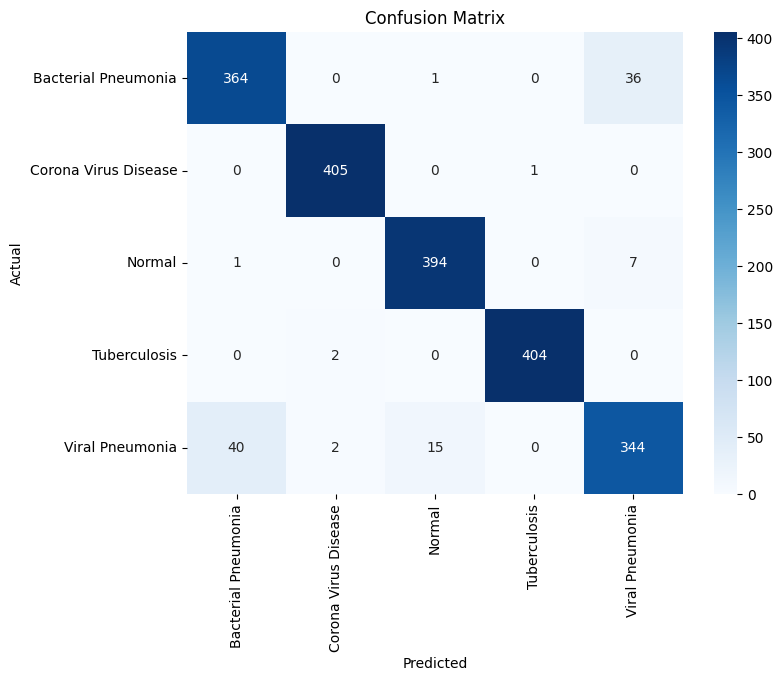

Final Validation Accuracy: 94.79%


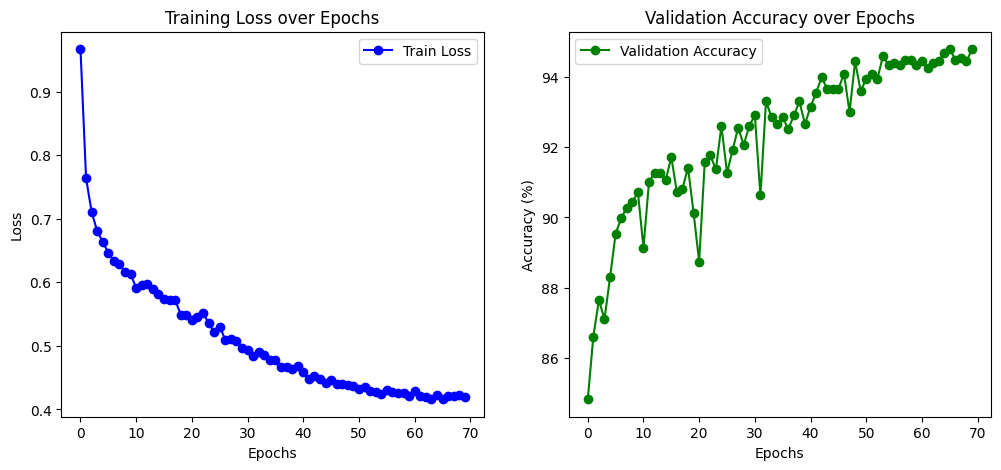

In [9]:
    # Final evaluation on the validation set with confusion matrix
    print("\nFinal Evaluation on Validation Set:")
    final_acc = evaluate_model(model, val_loader, show_cm=True)
    print(f"Final Validation Accuracy: {final_acc:.2f}%")

    # Plot Training Loss and Validation Accuracy over epochs
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], marker='o', color="blue", label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["val_acc"], marker='o', color="green", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()


<ipython-input-5-337849619c0e>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.

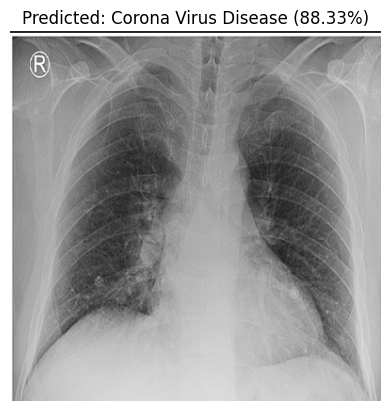

In [5]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_v2_s
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2

# Define class names
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis","Viral Pneumonia"]  # Modify according to your dataset




# Load the trained model
def load_model(model_path, num_classes):
    model = efficientnet_v2_s(weights=None)  # No pretrained weights
    in_features = model.classifier[1].in_features
    model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features, 1024),
        torch.nn.ReLU(),
        torch.nn.BatchNorm1d(1024),
        torch.nn.Dropout(0.4),
        torch.nn.Linear(1024, 512),
        torch.nn.ReLU(),
        torch.nn.BatchNorm1d(512),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(512, num_classes)
    )
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
    model.eval()
    return model

# Define test transform
test_transform = Compose([
    Resize(384, 384),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Function to test a single image
def predict_image(model, image_path, class_names):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply transformations
    transformed = test_transform(image=image)["image"]
    transformed = transformed.unsqueeze(0)  # Add batch dimension

    # Move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    transformed = transformed.to(device)

    # Model prediction
    with torch.no_grad():
        output = model(transformed)
        probs = torch.nn.functional.softmax(output, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_label].item()

    # Display the image and prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[pred_label]} ({confidence*100:.2f}%)")
    plt.show()

# Run prediction on a sample image
model = load_model("/kaggle/input/modelv2/best_model.pth", num_classes=len(classes))
sample_image_path = "/kaggle/input/covid19/Screenshot 2025-03-31 121504.png"  # Change this to your test image path
predict_image(model, sample_image_path, classes)


# **XAI- Gradcam**

<ipython-input-25-b4c02bf159c4>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Running Feature-Based Grad-CAM Explanation...


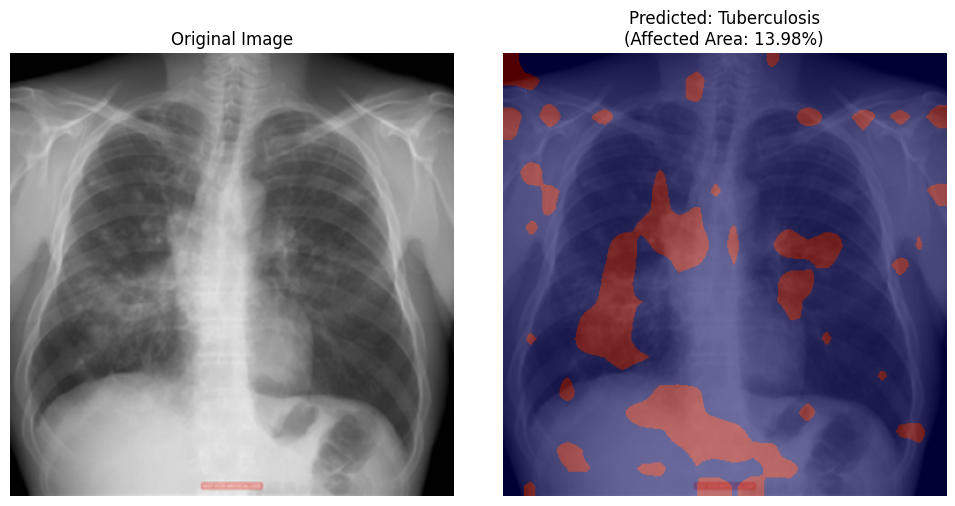


Predicted Class: Tuberculosis
Affected Area: 13.98% of the image


In [25]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S with the correct classifier
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your trained model's number of classes
)

# Load model weights
model_path = "/kaggle/input/modelv2/best_model.pth"  # Update with correct path
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")

model.to(device)
model.eval()

# --------------------------
# 2. Image Preprocessing
# --------------------------
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    image_np = np.array(image)
    image_np = cv2.resize(image_np, (384, 384))
    return image_np, image_tensor

# --------------------------
# 3. Grad-CAM Explanation (Feature-Based)
# --------------------------
def explain_gradcam(image_path):
    image_np, image_tensor = preprocess_image(image_path)
    
    gradients = None
    activations = None

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Choose an earlier feature extraction layer (not the last one)
    target_layer = model.features[-3]  # Using an earlier feature map for better spatial details
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)
    
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()
    predicted_label = classes[predicted_class]  # Convert index to class name
    
    model.zero_grad()
    output[0, predicted_class].backward()
    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze(0)

    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    # Use max across channels to extract the **most important** feature activations
    heatmap = torch.max(activations, dim=0)[0].cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    # --------------------------
    # 4. Generate Overlay Based on Feature Activations
    # --------------------------
    img_cv = cv2.imread(image_path)
    img_cv = cv2.resize(img_cv, (384, 384))

    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))

    # Create a binary mask for high-intensity feature activations
    threshold = 0.5  # Threshold for keeping strong activations
    binary_mask = np.uint8(heatmap_resized > threshold) * 255

    # Create **Red Overlay** for important features
    affected_regions = np.zeros_like(img_cv)
    affected_regions[:, :, 2] = binary_mask  # Red for strong feature activations

    # Create **Blue Overlay** for less relevant features
    unaffected_regions = np.zeros_like(img_cv)
    unaffected_regions[:, :, 0] = 255 - binary_mask  # Blue for low activation regions

    # Merge overlays with the original image
    overlay = cv2.addWeighted(img_cv, 0.6, affected_regions, 0.4, 0)
    overlay = cv2.addWeighted(overlay, 0.8, unaffected_regions, 0.2, 0)

    red_percentage = np.sum(binary_mask > 0) / (384 * 384) * 100

    # --------------------------
    # 5. Display Results
    # --------------------------
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_label}\n(Affected Area: {red_percentage:.2f}%)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return predicted_label, red_percentage

# --------------------------
# 6. Run Grad-CAM Explanation
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/testing/Tuberculosis-205.jpg"  # Update with your actual image

print("\nRunning Feature-Based Grad-CAM Explanation...")
predicted_class, red_area_percentage = explain_gradcam(image_path)
print(f"\nPredicted Class: {predicted_class}")
print(f"Affected Area: {red_area_percentage:.2f}% of the image")


<ipython-input-35-d3ce54a830a0>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Running Feature-Based Grad-CAM Explanation...


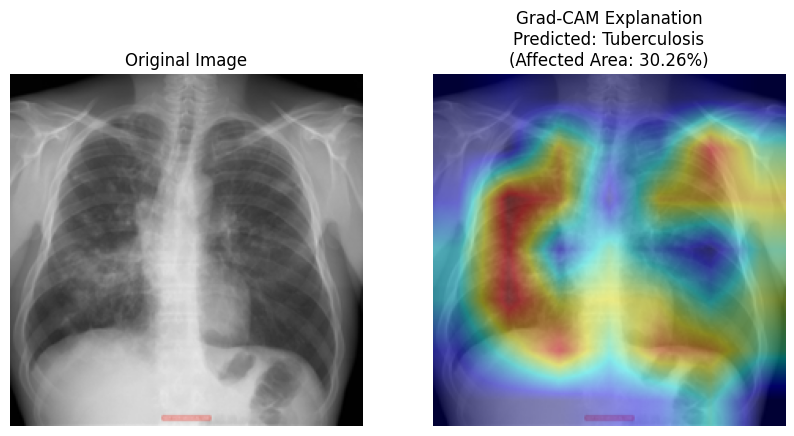


Predicted Class: Tuberculosis
Affected Area: 30.26% of the image


In [35]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S with the correct classifier
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your trained model's number of classes
)

# Load model weights
model_path = "/kaggle/input/modelv2/best_model.pth"  # Update with correct path
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")

model.to(device)
model.eval()

# --------------------------
# 2. Image Preprocessing
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to preprocess image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    image = Image.open(image_path).convert("RGB")
    image_resized = transform(image).unsqueeze(0).to(device)
    return image, image_resized

# --------------------------
# 3. Compute Red Area Percentage
# --------------------------
def calculate_red_area_percentage(heatmap):
    """
    Calculate the percentage of pixels in the heatmap that are strongly activated in red.
    We assume that higher red channel intensity represents stronger activation.
    """
    red_mask = heatmap[:, :, 2] > 150  # Threshold on red intensity
    red_percentage = np.sum(red_mask) / (heatmap.shape[0] * heatmap.shape[1]) * 100
    return red_percentage

# --------------------------
# 4. Grad-CAM Explanation (Updated)
# --------------------------
def explain_gradcam(image_path):
    image, image_tensor = preprocess_image(image_path)

    # Hook function to extract gradients
    gradients = None
    activations = None

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Select the last convolutional layer
    target_layer = model.features[-1]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Get model prediction
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()
    predicted_label = classes[predicted_class]  # Convert index to class name

    # Backpropagate for Grad-CAM
    model.zero_grad()
    output[0, predicted_class].backward()

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze(0)

    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = activations.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)

    # Load original image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    # Convert heatmap to color
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Compute Red Area Percentage
    red_percentage = calculate_red_area_percentage(heatmap)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM Explanation\nPredicted: {predicted_label}\n(Affected Area: {red_percentage:.2f}%)")
    plt.axis("off")

    plt.show()

    return predicted_label, red_percentage

# --------------------------
# 5. Run Grad-CAM Explanation
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/testing/Tuberculosis-205.jpg"  # Update with your actual image

print("\nRunning Feature-Based Grad-CAM Explanation...")
predicted_class, red_area_percentage = explain_gradcam(image_path)
print(f"\nPredicted Class: {predicted_class}")
print(f"Affected Area: {red_area_percentage:.2f}% of the image")


<ipython-input-17-176a36be963c>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Running Feature-Based Grad-CAM Explanation...


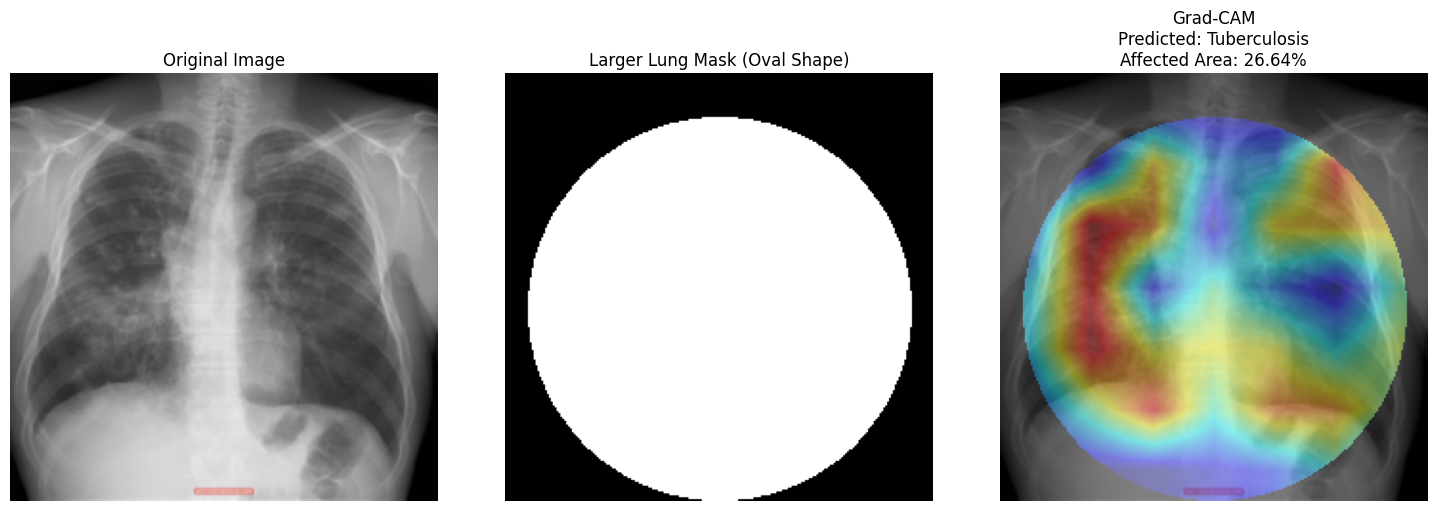


Predicted Class: Tuberculosis
Affected Area: 26.64% of the image


In [17]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S with the correct classifier
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Adjust based on your model
)

# Load model weights
model_path = "/kaggle/input/modelv2/best_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")

model.to(device)
model.eval()

# --------------------------
# 2. Image Preprocessing
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image, image_tensor

# --------------------------
# 3. Helper: Calculate Red Area Percentage
# --------------------------
def calculate_red_area_percentage(heatmap):
    """
    Calculate the percentage of pixels in the heatmap that are strongly activated in red.
    """
    red_mask = heatmap[:, :, 2] > 150  # Threshold on red intensity (BGR format)
    red_percentage = np.sum(red_mask) / (heatmap.shape[0] * heatmap.shape[1]) * 100
    return red_percentage

# --------------------------
# 4. Helper: Get Larger Oval Lung Mask
# --------------------------
def get_lung_mask(img_shape):
    """
    Create a **larger oval mask** approximating the lung region.
    """
    h, w = img_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    # Define center and increased size of the ellipse (lungs)
    center = (w // 2, int(h * 0.55))  # Center slightly below the middle
    axes = (int(w * 0.45), int(h * 0.45))  # **Increased width & height for larger lungs**
    
    # Draw the ellipse mask (white on black)
    cv2.ellipse(mask, center, axes, angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)

    return mask

# --------------------------
# 5. Grad-CAM Explanation (Updated with Larger Lung Mask)
# --------------------------
def explain_gradcam(image_path):
    image, image_tensor = preprocess_image(image_path)

    # Hook function to extract gradients and activations
    gradients = None
    activations = None

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Select the last convolutional layer
    target_layer = model.features[-1]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Get model prediction
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()
    predicted_label = classes[predicted_class]  # Convert index to class name

    # Backpropagate for Grad-CAM
    model.zero_grad()
    output[0, predicted_class].backward()

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze(0)
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]
    heatmap = activations.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    # Load original image using OpenCV and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    # Convert heatmap to color
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Get lung mask and apply it to the heatmap
    lung_mask = get_lung_mask(img.shape)
    heatmap_color_masked = cv2.bitwise_and(heatmap_color, heatmap_color, mask=lung_mask)

    # Blend the masked heatmap with the original image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color_masked, 0.4, 0)

    # Compute red area percentage only in the masked heatmap
    red_percentage = calculate_red_area_percentage(heatmap_color_masked)

    # Display results
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    
    # Larger Lung Mask
    plt.subplot(1, 3, 2)
    plt.imshow(lung_mask, cmap='gray')
    plt.title("Larger Lung Mask (Oval Shape)")
    plt.axis("off")
    
    # Grad-CAM Overlay (Lung Region Only)
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nPredicted: {predicted_label}\nAffected Area: {red_percentage:.2f}%")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return predicted_label, red_percentage

# --------------------------
# 6. Run Grad-CAM Explanation
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/testing/Tuberculosis-205.jpg"  # Update with your actual image path

print("\nRunning Feature-Based Grad-CAM Explanation...")
predicted_class, red_area_percentage = explain_gradcam(image_path)
print(f"\nPredicted Class: {predicted_class}")
print(f"Affected Area: {red_area_percentage:.2f}% of the image")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Running Grad-CAM Debug Explanation...
Raw Model Output (logits): tensor([[ 0.3809, -0.3587, -0.2620, -0.7251,  3.1794]])
Softmax Probabilities: tensor([[0.0533, 0.0254, 0.0280, 0.0176, 0.8755]])
Predicted Class Index: 4
Activations Shape: torch.Size([1, 1280, 7, 7])
Gradients Shape: torch.Size([1, 1280, 7, 7])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Sum of absolute gradients: 17.053733825683594
Red Area Percentage: 13.486527423469388


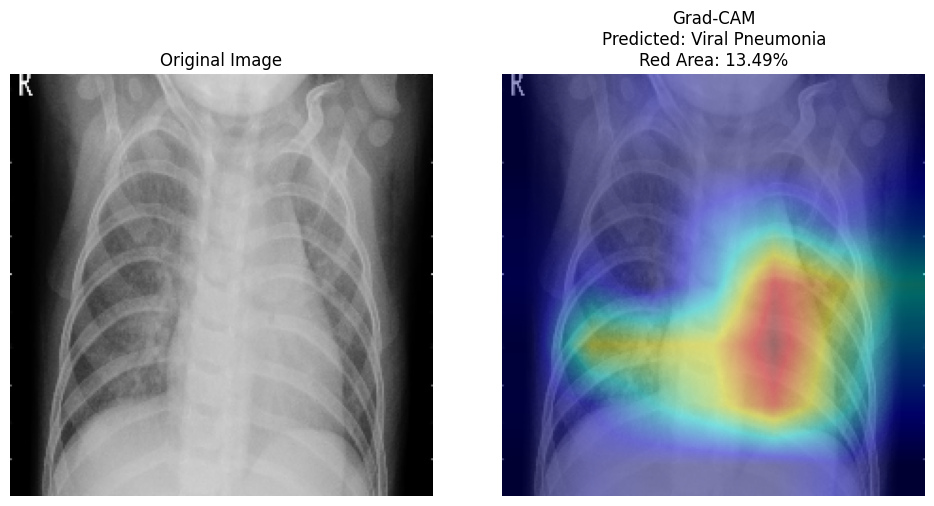


Predicted Class: Viral Pneumonia
Red Area: 13.49% of the image


In [16]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S with the correct classifier
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your model's number of classes
)

model_path = "/kaggle/input/modelv2/best_model.pth"  # Update with your path
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")
model.to(device)
model.eval()

# --------------------------
# 2. Image Preprocessing
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image, image_tensor

# --------------------------
# 3. Compute Red Area Percentage
# --------------------------
def calculate_red_area_percentage(heatmap):
    """
    Calculate the percentage of pixels in the heatmap (BGR) that are strongly activated in red.
    """
    red_mask = heatmap[:, :, 2] > 150  # Threshold on red intensity
    red_percentage = np.sum(red_mask) / (heatmap.shape[0] * heatmap.shape[1]) * 100
    return red_percentage

# --------------------------
# 4. Grad-CAM Explanation with Debug Info
# --------------------------
def explain_gradcam_debug(image_path):
    # Preprocess image
    image, image_tensor = preprocess_image(image_path)

    # Debug: Forward pass and softmax probabilities
    with torch.no_grad():
        output = model(image_tensor)
        softmax_probs = torch.softmax(output, dim=1)
        print("Raw Model Output (logits):", output)
        print("Softmax Probabilities:", softmax_probs)

    # Get predicted class index
    predicted_class = output.argmax(dim=1).item()
    print("Predicted Class Index:", predicted_class)
    predicted_label = classes[predicted_class]

    # Prepare to hook activations and gradients
    gradients = None
    activations = None

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]
        print("Gradients Shape:", gradients.shape)

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
        print("Activations Shape:", activations.shape)

    # Choose target layer; try model.features[-1] first. 
    target_layer = model.features[-1]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Forward pass (again, to get activations via the hook)
    output = model(image_tensor)

    # Backward pass for the predicted class
    model.zero_grad()
    output[0, predicted_class].backward()

    grad_sum = gradients.abs().sum().item()
    print("Sum of absolute gradients:", grad_sum)
    if grad_sum == 0:
        print("⚠️ WARNING: Zero gradients detected. Consider trying a different layer for Grad-CAM!")

    # Compute weighted activations
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze(0)
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    # Create heatmap from the activations
    heatmap = activations.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= (np.max(heatmap) + 1e-8)  # Normalize (avoid division by zero)

    # Load original image using OpenCV and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    # Resize heatmap to match image dimensions and apply colormap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Overlay heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    red_percentage = calculate_red_area_percentage(heatmap_color)
    print("Red Area Percentage:", red_percentage)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nPredicted: {predicted_label}\nRed Area: {red_percentage:.2f}%")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return predicted_label, red_percentage

# --------------------------
# 5. Run Grad-CAM Debug Explanation
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/newtest/person53_virus_107.jpeg"  # Update with your image path

print("\nRunning Grad-CAM Debug Explanation...")
predicted_class, red_area_percentage = explain_gradcam_debug(image_path)
print(f"\nPredicted Class: {predicted_class}")
print(f"Red Area: {red_area_percentage:.2f}% of the image")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Running LIME Explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

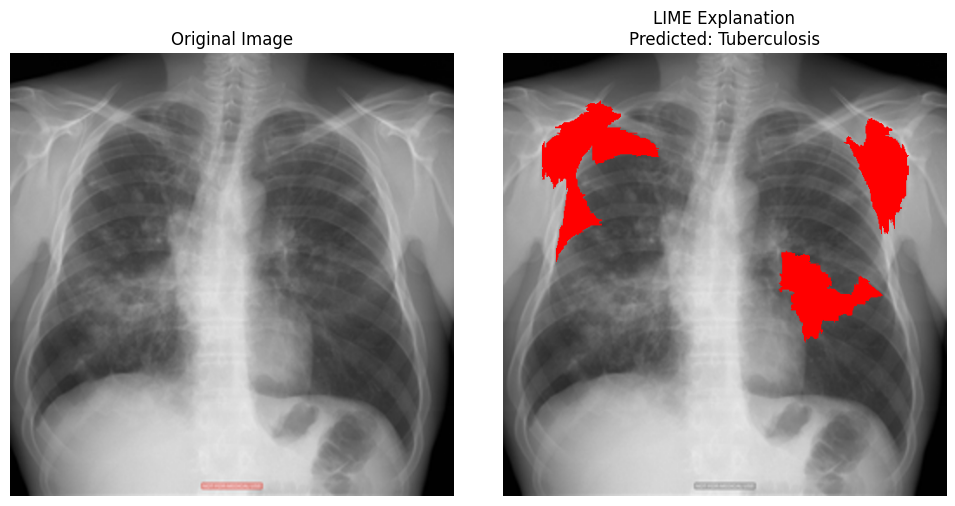


Predicted Class: Tuberculosis


In [18]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from lime import lime_image
from skimage.segmentation import mark_boundaries

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your model's number of classes
)

# Load trained model weights
model_path = "/kaggle/input/modelv2/best_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")

model.to(device)
model.eval()

# --------------------------
# 2. Image Preprocessing
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    image = Image.open(image_path).convert("RGB")
    image_resized = transform(image).unsqueeze(0).to(device)
    return image, image_resized

# --------------------------
# 3. LIME Explanation
# --------------------------
def predict_proba(images):
    """ Convert images to model input and return probabilities. """
    images_tensor = torch.stack([transform(Image.fromarray(img)) for img in images])
    images_tensor = images_tensor.to(device)

    with torch.no_grad():
        outputs = model(images_tensor)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
    
    return probabilities

def explain_lime(image_path, num_samples=1000):
    """
    Generate LIME explanation for an image, highlighting important regions in red.
    """
    image, _ = preprocess_image(image_path)
    image_np = np.array(image)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image_np, 
        predict_proba, 
        top_labels=5, 
        hide_color=0, 
        num_samples=num_samples
    )

    # Get LIME explanation for the predicted class
    pred_label = np.argmax(predict_proba([image_np]))
    temp, mask = explanation.get_image_and_mask(pred_label, positive_only=True, hide_rest=False)

    # Convert to grayscale for non-important areas
    grayscale = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
    grayscale = cv2.cvtColor(grayscale, cv2.COLOR_GRAY2RGB)

    # Create a red overlay for highlighted regions
    red_highlight = np.zeros_like(temp)
    red_highlight[:, :, 0] = 255  # Set red channel to 255

    # Apply the mask: Important areas in red, others in grayscale
    highlighted_image = np.where(mask[:, :, None], red_highlight, grayscale)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted_image)
    plt.title(f"LIME Explanation\nPredicted: {classes[pred_label]}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return classes[pred_label]

# --------------------------
# 4. Run LIME Explanation
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/testing/Tuberculosis-205.jpg"  # Update with your image path

print("\nRunning LIME Explanation...")
predicted_label = explain_lime(image_path)
print(f"\nPredicted Class: {predicted_label}")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Running SHAP Explanation...


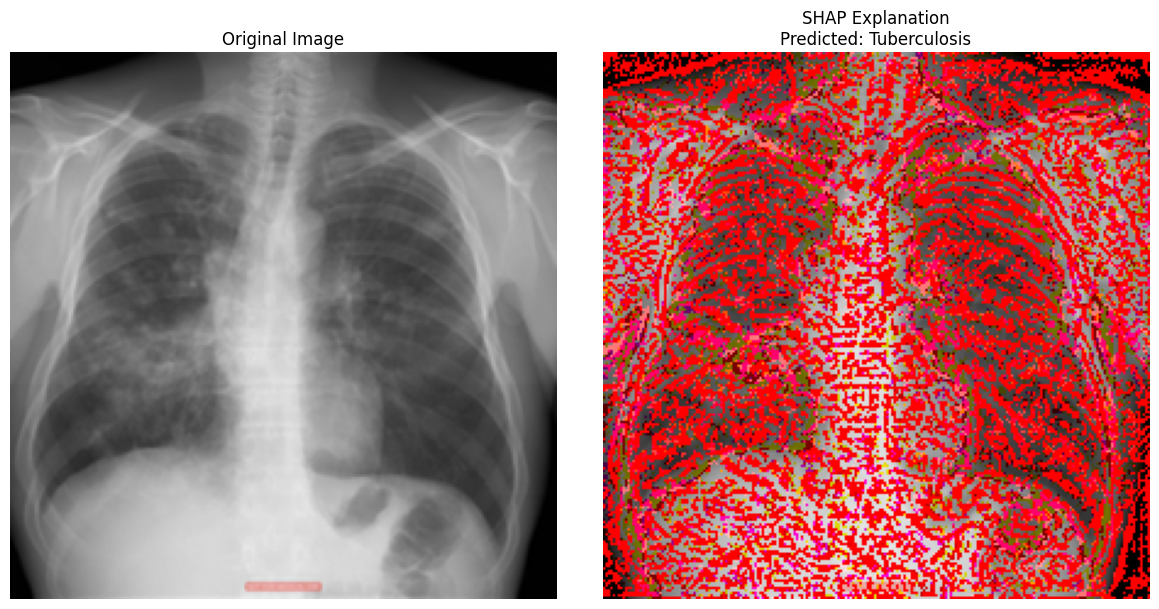


Predicted Class: Tuberculosis


In [19]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import shap

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your model's number of classes
)

model_path = "/kaggle/input/modelv2/best_model.pth"  # Update with your path
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")

model.to(device)
model.eval()

# Define class labels
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]

# --------------------------
# 2. Image Preprocessing
# --------------------------
model_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    return Image.open(image_path).convert("RGB")

def preprocess_for_model(image):
    """Transform image for model inference; output shape: (1, 3, 224, 224)."""
    return model_transform(image).unsqueeze(0).to(device)

# --------------------------
# 3. SHAP Explanation Function (Fixed)
# --------------------------
def explain_shap(image_path, num_samples=100):
    """
    Generate SHAP explanation for an image and highlight important regions in red.
    """
    # Load and preprocess the image
    image = load_image(image_path)
    image_tensor = preprocess_for_model(image)
    
    # Convert image to numpy array in [0,1] range for visualization
    image_np = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

    # Create background tensor (black image)
    background = torch.zeros((1, 3, 224, 224)).to(device)

    # Use SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, background)

    # Compute SHAP values
    shap_values = explainer.shap_values(image_tensor.clone().detach())  # Clone to avoid in-place modification error
    
    # Get predicted class
    predicted_class = model(image_tensor).argmax(dim=1).item()
    shap_val = shap_values[predicted_class]  # Shape: (1, 3, 224, 224)

    # Convert SHAP values to shape (224, 224, 3) for visualization
    shap_val = np.transpose(shap_val.squeeze(), (1, 2, 0))  # Fix: No `.cpu()` needed

    # Create an importance mask where SHAP values are positive
    importance_mask = shap_val > 0

    # Create a red overlay
    red_overlay = np.zeros_like(image_np)
    red_overlay[..., 0] = 1.0  # Set red channel to 1

    # Apply the red overlay to important regions
    highlighted = np.where(importance_mask, red_overlay, image_np)
    highlighted = np.clip(highlighted, 0, 1)

    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted)
    plt.title(f"SHAP Explanation\nPredicted: {classes[predicted_class]}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return classes[predicted_class]

# --------------------------
# 4. Run SHAP Explanation
# --------------------------
image_path = "/kaggle/input/testing/Tuberculosis-205.jpg"  # Update with your image path

print("\nRunning SHAP Explanation...")
predicted_label = explain_shap(image_path)
print(f"\nPredicted Class: {predicted_label}")


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage import measure, filters, morphology

# --------------------------
# 1. Device Setup
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# 2. Classification Model: EfficientNet-V2-S
# --------------------------
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # 5 classes
)

model_path = "/kaggle/input/modelv2/best_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Classification model file '{model_path}' not found!")
model.to(device)
model.eval()

# --------------------------
# 3. Image Preprocessing and Normalization
# --------------------------
# For classification (Grad-CAM)
cls_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image_for_cls(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    image = Image.open(image_path).convert("RGB")
    
    # Store the original image for visualization
    orig_image = np.array(image)
    
    # Apply histogram equalization to enhance contrast
    if len(orig_image.shape) == 3:  # RGB image
        img_yuv = cv2.cvtColor(orig_image, cv2.COLOR_RGB2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        enhanced_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        enhanced_pil = Image.fromarray(enhanced_img)
    else:  # Grayscale image
        enhanced_img = cv2.equalizeHist(orig_image)
        enhanced_pil = Image.fromarray(enhanced_img)
    
    # Convert to tensor for model input
    image_tensor = cls_transform(enhanced_pil).unsqueeze(0).to(device)
    
    return image, image_tensor, enhanced_img

# --------------------------
# 4. Robust Lung Segmentation
# --------------------------
def segment_lungs(image_array):
    """
    Segment lungs using traditional image processing techniques
    Works on both training and new X-ray images
    """
    # Convert to grayscale if needed
    if len(image_array.shape) == 3:
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_array.copy()
    
    # Apply CLAHE for better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray.astype(np.uint8))
    
    # Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Multi-threshold approach
    masks = []
    
    # Try multiple thresholding methods and combine them
    # 1. Otsu's method
    otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[0]
    mask_otsu = blurred < otsu_thresh
    masks.append(mask_otsu)
    
    # 2. Adaptive thresholding
    mask_adaptive = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    ) > 0
    masks.append(mask_adaptive)
    
    # 3. Fixed thresholds for different intensity ranges
    mask_low = blurred < 70  # For dark regions
    masks.append(mask_low)
    
    mask_mid = (blurred > 70) & (blurred < 140)  # For mid-intensity
    masks.append(mask_mid)
    
    # Combine masks
    combined_mask = np.zeros_like(mask_otsu, dtype=bool)
    for mask in masks:
        combined_mask |= mask
    
    # Post-processing
    # Remove small objects
    clean_mask = morphology.remove_small_objects(combined_mask, min_size=200)
    
    # Fill holes
    filled_mask = morphology.remove_small_holes(clean_mask, area_threshold=2000)
    
    # Find connected components
    labeled, num = measure.label(filled_mask, return_num=True)
    
    # Keep the largest components that are likely to be lungs
    if num > 2:
        props = measure.regionprops(labeled)
        areas = [prop.area for prop in props]
        
        # Sort by area (descending)
        sorted_regions = sorted(zip(range(1, num+1), areas), key=lambda x: x[1], reverse=True)
        
        # Keep the two largest regions (potential lungs)
        final_mask = np.zeros_like(filled_mask)
        for i in range(min(2, len(sorted_regions))):
            final_mask[labeled == sorted_regions[i][0]] = 1
            
        # If the two largest regions are very different in size, there might be an issue
        # Add the third largest region as well if it's comparable in size
        if len(sorted_regions) > 2:
            largest_area = sorted_regions[0][1]
            third_area = sorted_regions[2][1]
            if third_area > largest_area * 0.3:  # Third region is at least 30% of largest
                final_mask[labeled == sorted_regions[2][0]] = 1
    else:
        # If we found 2 or fewer regions, keep them all
        final_mask = filled_mask
    
    # Final morphological operations
    kernel = np.ones((5, 5), np.uint8)
    final_mask = cv2.morphologyEx(final_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)
    final_mask = cv2.dilate(final_mask, np.ones((3, 3), np.uint8), iterations=2)
    
    # Create geometrical constraints - lung regions should be in the central area
    # Create a crude mask that restricts detection to the central 70% of the image
    h, w = final_mask.shape
    margin_h, margin_w = int(h * 0.15), int(w * 0.15)
    geo_mask = np.zeros_like(final_mask)
    geo_mask[margin_h:h-margin_h, margin_w:w-margin_w] = 1
    
    # Apply geometric constraint
    final_mask = final_mask & geo_mask
    
    # If result is too small or empty, use fallback approach
    if np.sum(final_mask) < 0.05 * h * w:
        # Create a simple elliptical mask as last resort
        center = (w // 2, h // 2)
        axes = (w // 3, h // 2)
        angle = 0
        fallback_mask = np.zeros_like(final_mask)
        cv2.ellipse(fallback_mask, center, axes, angle, 0, 360, 1, -1)
        final_mask = fallback_mask
    
    return (final_mask * 255).astype(np.uint8)

# --------------------------
# 5. Enhanced GradCAM Implementation
# --------------------------
def explain_gradcam_new(image_path, layer_name='features.7', alpha=0.7):
    """
    Enhanced GradCAM implementation that works well with new X-ray images.
    
    Parameters:
    - image_path: Path to the X-ray image
    - layer_name: Target layer for GradCAM (earlier layers might work better for new images)
    - alpha: Weight for blending original image with heatmap
    """
    # Load and preprocess image
    original_pil, image_tensor, enhanced_img = preprocess_image_for_cls(image_path)
    
    # Get lung mask using traditional methods
    lung_mask = segment_lungs(enhanced_img)
    
    # Resize lung mask to 224x224 to match the model input size
    lung_mask_resized = cv2.resize(lung_mask, (224, 224))
    
    # Calculate lung coverage
    lung_coverage = np.sum(lung_mask_resized) / (lung_mask_resized.shape[0] * lung_mask_resized.shape[1] * 255) * 100
    
    # Get the target layer
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    
    if target_layer is None:
        print(f"Layer {layer_name} not found, using last convolutional layer")
        # Find the last convolutional layer
        for name, module in reversed(list(model.named_modules())):
            if isinstance(module, torch.nn.Conv2d):
                target_layer = module
                layer_name = name
                print(f"Using layer: {layer_name}")
                break
    
    # Setup hooks for GradCAM
    gradients = []
    activations = None
    
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())
    
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output.detach()
    
    # Register hooks
    handle1 = target_layer.register_forward_hook(forward_hook)
    handle2 = target_layer.register_full_backward_hook(backward_hook)
    
    # Forward pass
    model.zero_grad()
    output = model(image_tensor)
    
    # Get prediction
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0, predicted_class].item() * 100
    predicted_label = classes[predicted_class]
    
    # Generate heatmap for predicted class
    model.zero_grad()
    output[0, predicted_class].backward(retain_graph=True)
    
    # Generate Grad-CAM
    with torch.no_grad():
        # Check if gradients were captured
        if len(gradients) == 0:
            print("Warning: No gradients captured. This may indicate an issue with the model.")
            heatmap = np.zeros((7, 7))  # Default size for visualization
        else:
            # Get the gradients
            gradients = gradients[0]
            
            # Average gradients across spatial dimensions
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
            
            # Weight feature maps by gradients
            weighted_activations = activations.clone()
            for i in range(activations.shape[1]):
                weighted_activations[0, i, :, :] *= pooled_gradients[i]
            
            # Average across feature maps
            heatmap = torch.mean(weighted_activations, dim=1).squeeze().cpu().numpy()
            
            # ReLU to keep only positive contributions
            heatmap = np.maximum(heatmap, 0)
            
            # Normalize
            if np.max(heatmap) > 0:
                heatmap = heatmap / np.max(heatmap)
    
    # Clean up hooks
    handle1.remove()
    handle2.remove()
    
    # Clear gradients list for the next call
    gradients.clear()
    
    # Get original image for visualization
    img = np.array(original_pil.resize((224, 224)))
    
    # Create overlay versions with multiple colormap options
    colormaps = [cv2.COLORMAP_JET, cv2.COLORMAP_HOT, cv2.COLORMAP_VIRIDIS]
    overlay_images = []
    
    for cmap in colormaps:
        # Resize heatmap to match image dimensions
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        
        # Convert heatmap to RGB colormap
        heatmap_rgb = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cmap)
        
        # Make heatmap compatible with input image
        if len(img.shape) == 2:  # If grayscale image
            img_display = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_display = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        # Apply lung mask to heatmap (with proper size check)
        # Ensure mask is proper size and type
        if lung_mask_resized.shape[:2] != heatmap_rgb.shape[:2]:
            lung_mask_resized = cv2.resize(lung_mask_resized, (heatmap_rgb.shape[1], heatmap_rgb.shape[0]))
        
        # Ensure mask is proper type (CV_8U)
        lung_mask_resized = lung_mask_resized.astype(np.uint8)
        
        # Apply mask
        masked_heatmap = cv2.bitwise_and(heatmap_rgb, heatmap_rgb, mask=lung_mask_resized)
        
        # Create overlay
        overlay = cv2.addWeighted(img_display, 1-alpha, masked_heatmap, alpha, 0)
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        overlay_images.append(overlay_rgb)
    
    # Get enhanced image for display
    enhanced_display = cv2.resize(enhanced_img, (224, 224))
    if len(enhanced_display.shape) == 2:
        enhanced_display = cv2.cvtColor(enhanced_display, cv2.COLOR_GRAY2RGB)
    
    # Calculate overlap metrics
    high_activation = (heatmap_resized > 0.5).astype(np.uint8)
    high_activation_in_lungs = cv2.bitwise_and(high_activation, high_activation, mask=lung_mask_resized)
    
    if np.sum(high_activation) > 0:
        overlap_percentage = (np.sum(high_activation_in_lungs) / np.sum(high_activation)) * 100
    else:
        overlap_percentage = 0
    
    # Calculate activation intensity in lung region
    if np.sum(lung_mask_resized) > 0:
        lung_activation_mean = np.mean(heatmap_resized[lung_mask_resized > 0]) * 100
    else:
        lung_activation_mean = 0
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(img if len(img.shape) == 3 else plt.cm.gray(img))
    plt.title("Original Image")
    plt.axis("off")
    
    # Enhanced image
    plt.subplot(2, 3, 2)
    plt.imshow(enhanced_display)
    plt.title("Enhanced Image")
    plt.axis("off")
    
    # Lung mask
    plt.subplot(2, 3, 3)
    plt.imshow(lung_mask_resized, cmap='gray')
    plt.title(f"Lung Mask\nCoverage: {lung_coverage:.1f}%")
    plt.axis("off")
    
    # GradCAM overlays with different colormaps
    for i, (overlay, cmap_name) in enumerate(zip(overlay_images, ['Jet', 'Hot', 'Viridis'])):
        plt.subplot(2, 3, 4+i)
        plt.imshow(overlay)
        plt.title(f"GradCAM {cmap_name}\n{predicted_label} ({confidence:.1f}%)")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Print additional metrics
    print(f"\nPredicted: {predicted_label} with {confidence:.2f}% confidence")
    print(f"Lung coverage: {lung_coverage:.2f}%")
    print(f"Activation-lung overlap: {overlap_percentage:.2f}%")
    print(f"Mean activation in lung region: {lung_activation_mean:.2f}%")
    
    return {
        "predicted_class": predicted_label,
        "confidence": confidence,
        "lung_coverage": lung_coverage,
        "overlap_percentage": overlap_percentage,
        "lung_activation": lung_activation_mean,
        "heatmap": heatmap,
        "lung_mask": lung_mask_resized
    }

# --------------------------
# 6. Multi-layer GradCAM Analysis
# --------------------------
def analyze_multiple_layers(image_path, layers=None):
    """
    Generate GradCAM visualizations from multiple layers to find the best one for new images
    """
    if layers is None:
        # Default layers to try - from earlier to later
        layers = ['features.1', 'features.3', 'features.5', 'features.7', 'features.8']
    
    results = {}
    plt.figure(figsize=(15, 4*len(layers)))
    
    # Load and preprocess image once
    original_pil, image_tensor, enhanced_img = preprocess_image_for_cls(image_path)
    
    # Get lung mask
    lung_mask = segment_lungs(enhanced_img)
    
    # Resize lung mask to 224x224 to match the model input size
    lung_mask_resized = cv2.resize(lung_mask, (224, 224))
    
    # Original image
    plt.subplot(len(layers)+1, 3, 1)
    img = np.array(original_pil.resize((224, 224)))
    plt.imshow(img if len(img.shape) == 3 else plt.cm.gray(img))
    plt.title("Original Image")
    plt.axis("off")
    
    # Enhanced image
    plt.subplot(len(layers)+1, 3, 2)
    enhanced_display = cv2.resize(enhanced_img, (224, 224))
    if len(enhanced_display.shape) == 2:
        enhanced_display = cv2.cvtColor(enhanced_display, cv2.COLOR_GRAY2RGB)
    plt.imshow(enhanced_display)
    plt.title("Enhanced Image")
    plt.axis("off")
    
    # Lung mask
    plt.subplot(len(layers)+1, 3, 3)
    plt.imshow(lung_mask_resized, cmap='gray')
    plt.title("Lung Mask")
    plt.axis("off")
    
    # Forward pass once
    output = model(image_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0, predicted_class].item() * 100
    predicted_label = classes[predicted_class]
    
    # For each layer
    for i, layer_name in enumerate(layers):
        # Get the target layer
        target_layer = None
        for name, module in model.named_modules():
            if name == layer_name:
                target_layer = module
                break
        
        if target_layer is None:
            print(f"Layer {layer_name} not found, skipping")
            continue
        
        # Setup hooks for GradCAM
        gradients = []
        activations = None
        
        def backward_hook(module, grad_in, grad_out):
            gradients.append(grad_out[0].detach())
        
        def forward_hook(module, input, output):
            nonlocal activations
            activations = output.detach()
        
        # Register hooks
        handle1 = target_layer.register_forward_hook(forward_hook)
        handle2 = target_layer.register_full_backward_hook(backward_hook)
        
        # Forward pass again (needed to collect activations)
        model.zero_grad()
        output = model(image_tensor)
        
        # Backward pass
        model.zero_grad()
        output[0, predicted_class].backward(retain_graph=True)
        
        # Generate Grad-CAM
        with torch.no_grad():
            # Check if gradients were captured
            if len(gradients) == 0:
                print(f"Warning: No gradients captured for layer {layer_name}")
                heatmap = np.zeros((7, 7))  # Default size for visualization
            else:
                # Get the gradients
                gradient = gradients[0]
                
                # Average gradients across spatial dimensions
                pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])
                
                # Weight feature maps by gradients
                weighted_activations = activations.clone()
                for j in range(activations.shape[1]):
                    weighted_activations[0, j, :, :] *= pooled_gradients[j]
                
                # Average across feature maps
                heatmap = torch.mean(weighted_activations, dim=1).squeeze().cpu().numpy()
                
                # ReLU to keep only positive contributions
                heatmap = np.maximum(heatmap, 0)
                
                # Normalize
                if np.max(heatmap) > 0:
                    heatmap = heatmap / np.max(heatmap)
        
        # Clean up hooks
        handle1.remove()
        handle2.remove()
        
        # Clear gradients list for the next call
        gradients.clear()
        
        # Resize heatmap to match image dimensions
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        
        # Convert heatmap to RGB colormap
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        
        # Make heatmap compatible with input image
        if len(img.shape) == 2:  # If grayscale image
            img_display = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_display = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        # Apply lung mask to heatmap (with proper size check)
        # Ensure mask is proper size and type
        if lung_mask_resized.shape[:2] != heatmap_color.shape[:2]:
            lung_mask_resized = cv2.resize(lung_mask_resized, (heatmap_color.shape[1], heatmap_color.shape[0]))
        
        # Ensure mask is proper type (CV_8U)
        lung_mask_resized = lung_mask_resized.astype(np.uint8)
        
        # Apply mask
        masked_heatmap = cv2.bitwise_and(heatmap_color, heatmap_color, mask=lung_mask_resized)
        
        # Create overlay
        overlay = cv2.addWeighted(img_display, 0.6, masked_heatmap, 0.4, 0)
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        
        # Calculate metrics
        # High activation in lung region
        high_activation = (heatmap_resized > 0.5).astype(np.uint8)
        high_activation_in_lungs = cv2.bitwise_and(high_activation, high_activation, mask=lung_mask_resized)
        
        if np.sum(high_activation) > 0:
            overlap_percentage = (np.sum(high_activation_in_lungs) / np.sum(high_activation)) * 100
        else:
            overlap_percentage = 0
        
        # Store results
        results[layer_name] = {
            "heatmap": heatmap,
            "overlap_percentage": overlap_percentage
        }
        
        # Display heatmap
        plt.subplot(len(layers)+1, 3, (i+1)*3 + 1)
        plt.imshow(heatmap, cmap='jet')
        plt.title(f"Layer: {layer_name}\nHeatmap")
        plt.axis("off")
        
        # Display masked heatmap
        plt.subplot(len(layers)+1, 3, (i+1)*3 + 2)
        plt.imshow(cv2.cvtColor(masked_heatmap, cv2.COLOR_BGR2RGB))
        plt.title(f"Masked Heatmap\nOverlap: {overlap_percentage:.1f}%")
        plt.axis("off")
        
        # Display overlay
        plt.subplot(len(layers)+1, 3, (i+1)*3 + 3)
        plt.imshow(overlay_rgb)
        plt.title(f"GradCAM Overlay\n{predicted_label} ({confidence:.1f}%)")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Find best layer (highest overlap)
    if results:
        best_layer = max(results.items(), key=lambda x: x[1]["overlap_percentage"])
        print(f"\nBest layer for this image: {best_layer[0]} with {best_layer[1]['overlap_percentage']:.2f}% overlap")
        print(f"Predicted: {predicted_label} with {confidence:.2f}% confidence")
    else:
        print("\nNo valid results found for any layer")
    
    return results, predicted_label, confidence

# --------------------------
# 7. Batch Processing Function
# --------------------------
def process_batch(image_dir, output_dir=None, save_results=False):
    """
    Process a batch of images and determine best GradCAM layer for each
    """
    results = []
    
    # Create output directory if needed
    if save_results and output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Processing {len(image_files)} images...")
    
    for img_file in image_files:
        image_path = os.path.join(image_dir, img_file)
        print(f"\nProcessing {img_file}...")
        
        # Run standard GradCAM
        result = explain_gradcam_new(image_path)
        
        # Store results
        results.append({
            "filename": img_file,
            "predicted_class": result["predicted_class"],
            "confidence": result["confidence"],
            "lung_coverage": result["lung_coverage"],
            "activation_overlap": result["overlap_percentage"]
        })
        
        # Save figure if requested
        if save_results and output_dir:
            plt.savefig(os.path.join(output_dir, f"{os.path.splitext(img_file)[0]}_result.png"))
            plt.close()
    
    # Create a summary report
    if save_results and output_dir:
        import pandas as pd
        df = pd.DataFrame(results)
        df.to_csv(os.path.join(output_dir, "batch_results.csv"), index=False)
        
        # Print summary statistics
        print("\nSummary Statistics:")
        print(f"Total images processed: {len(results)}")
        print(f"Class distribution: {df['predicted_class'].value_counts().to_dict()}")
        print(f"Average confidence: {df['confidence'].mean():.2f}%")
        print(f"Average lung coverage: {df['lung_coverage'].mean():.2f}%")
    
    return results

# --------------------------
# 8. Run the Improved GradCAM
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/testing/Tuberculosis-205.jpg"  # Update with your image path

print("\nRunning Enhanced GradCAM for new X-ray images...")
print("\n1. Standard GradCAM with improved processing:")
result = explain_gradcam_new(image_path)

print("\n2. Multi-layer analysis to find optimal visualization:")
layer_results, pred_class, conf = analyze_multiple_layers(image_path)

# Example usage of batch processing:
# process_batch("/kaggle/input/testing", "/kaggle/output/results", save_results=True)

<ipython-input-1-98e3567b10d3>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Running Enhanced GradCAM for new X-ray images...

1. Standard GradCAM with improved processing:


AttributeError: 'Tensor' object has no attribute 'clear'

In [9]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import csv

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your trained model's number of classes
)

# Load model weights safely
model_path = "/kaggle/input/modelv2/best_model.pth"  # Update with correct path
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=False)

model.to(device)
model.eval()

# --------------------------
# 2. Grad-CAM Layer Selection
# --------------------------
target_layer = model.features[-1]  # Update if necessary

# --------------------------
# 3. Image Preprocessing
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    """Loads and preprocesses an image for inference."""
    image = Image.open(image_path).convert("RGB")
    image_resized = transform(image).unsqueeze(0).to(device)
    return image, image_resized

# --------------------------
# 4. Compute Red Area Percentage
# --------------------------
def calculate_red_area_percentage(heatmap):
    """Calculate the percentage of red pixels in the heatmap."""
    red_mask = heatmap[:, :, 2] > 150  # Threshold on red intensity
    red_percentage = np.sum(red_mask) / (heatmap.shape[0] * heatmap.shape[1]) * 100
    return red_percentage

# --------------------------
# 5. Grad-CAM Explanation
# --------------------------
def generate_gradcam(image_path, save_path):
    """Generates and saves the Grad-CAM heatmap."""
    image, image_tensor = preprocess_image(image_path)

    # Hook function to capture activations and gradients
    gradients = None
    activations = None

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Register hooks
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Get model prediction
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()
    predicted_label = classes[predicted_class]

    # Backpropagate for Grad-CAM
    model.zero_grad()
    output[0, predicted_class].backward()

    if gradients is None or activations is None:
        return None, None, None

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze(0)

    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = activations.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)

    # Load and resize original image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    # Convert heatmap to color
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Compute Red Area Percentage
    red_percentage = calculate_red_area_percentage(heatmap)

    # Save heatmap image
    cv2.imwrite(save_path, superimposed_img)

    # Release hooks
    handle_forward.remove()
    handle_backward.remove()

    return os.path.basename(image_path), predicted_label, red_percentage

# --------------------------
# 6. Process All Images in the Test Dataset
# --------------------------
test_dataset_path = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/test"  # Update path
output_folder = "/kaggle/working/heatmaps"
csv_output = "/kaggle/working/heatmap_results.csv"

os.makedirs(output_folder, exist_ok=True)

classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
results = []

# Process each class folder
for class_folder in os.listdir(test_dataset_path):
    class_path = os.path.join(test_dataset_path, class_folder)

    if not os.path.isdir(class_path):
        continue

    class_output_folder = os.path.join(output_folder, class_folder)
    os.makedirs(class_output_folder, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        if img_path.lower().endswith((".jpg", ".jpeg", ".png")):
            save_path = os.path.join(class_output_folder, f"heatmap_{img_name}")

            img_name, pred_label, red_area = generate_gradcam(img_path, save_path)

            if img_name is not None:
                results.append([img_name, class_folder, pred_label, red_area])

# --------------------------
# 7. Save Results to CSV
# --------------------------
with open(csv_output, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Image Name", "True Label", "Predicted Label", "Affected Area (%)"])
    writer.writerows(results)

print(f"\n✅ Heatmap images saved in: {output_folder}")
print(f"✅ CSV results saved at: {csv_output}")


<ipython-input-9-cbbef4208a2f>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)
<ipython-input-9-cbbef4208a2f>:113:


✅ Heatmap images saved in: /kaggle/working/heatmaps
✅ CSV results saved at: /kaggle/working/heatmap_results.csv


In [21]:
import csv

# Input and Output CSV Paths
csv_input = "/kaggle/input/heatmapcsv/heatmap_results (4).csv"
csv_output = "/kaggle/working/heatmap_results_with_severity.csv"

# Severity Classification and Recommendations
def classify_severity(red_area):
    if red_area < 10:
        return "Mild"
    elif 10 <= red_area < 30:
        return "Moderate"
    else:
        return "Severe"

def get_recommendation(pred_label, severity=None):
    recommendations = {
        "Bacterial Pneumonia": {
            "Mild": "Antibiotics, rest, hydration, avoid smoking.",
            "Moderate": "Doctor consultation, prescribed antibiotics, oxygen monitoring.",
            "Severe": "Hospitalization, IV antibiotics, oxygen therapy."
        },
        "Corona Virus Disease": {
            "Mild": "Home isolation, symptomatic treatment, hydration.",
            "Moderate": "Doctor consultation, antiviral medication, oxygen monitoring.",
            "Severe": "Hospitalization, oxygen support, ventilatory support if needed."
        },
        "Normal": {
            "General": "No medical intervention required. Maintain a healthy lifestyle."
        },
        "Tuberculosis": {
            "Mild": "Start anti-TB medication (DOTS), proper nutrition.",
            "Moderate": "Doctor consultation, strict adherence to TB medication.",
            "Severe": "Hospitalization, isolation, long-term TB treatment."
        },
        "Viral Pneumonia": {
            "Mild": "Symptomatic treatment, rest, hydration.",
            "Moderate": "Doctor consultation, antiviral medication, oxygen monitoring.",
            "Severe": "Hospitalization, antiviral treatment, respiratory support."
        }
    }
    
    if pred_label == "Normal":
        return recommendations["Normal"]["General"]
    return recommendations.get(pred_label, {}).get(severity, "Consult a healthcare professional.")

# Read CSV, process data, and write new CSV
updated_results = []

with open(csv_input, mode="r") as file:
    reader = csv.reader(file)
    header = next(reader)  # Read header

    # New header: Remove "Affected Area (%)" and "Severity" for Normal cases
    updated_results.append(["Image Name", "True Label", "Predicted Label", "Affected Area (%)", "Severity", "Recommendation"])

    for row in reader:
        img_name, true_label, pred_label, red_area = row
        red_area = float(red_area)  # Convert red area to float

        if pred_label == "Normal":
            updated_results.append([img_name, true_label, pred_label, "", "", get_recommendation(pred_label)])
        else:
            severity = classify_severity(red_area)
            recommendation = get_recommendation(pred_label, severity)
            updated_results.append([img_name, true_label, pred_label, f"{red_area:.2f}", severity, recommendation])

# Write updated CSV
with open(csv_output, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(updated_results)

print(f"✅ Updated CSV with severity and recommendations saved at: {csv_output}")


✅ Updated CSV with severity and recommendations saved at: /kaggle/working/heatmap_results_with_severity.csv


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Running Grad-CAM with Detailed Report and Extra Visualizations...


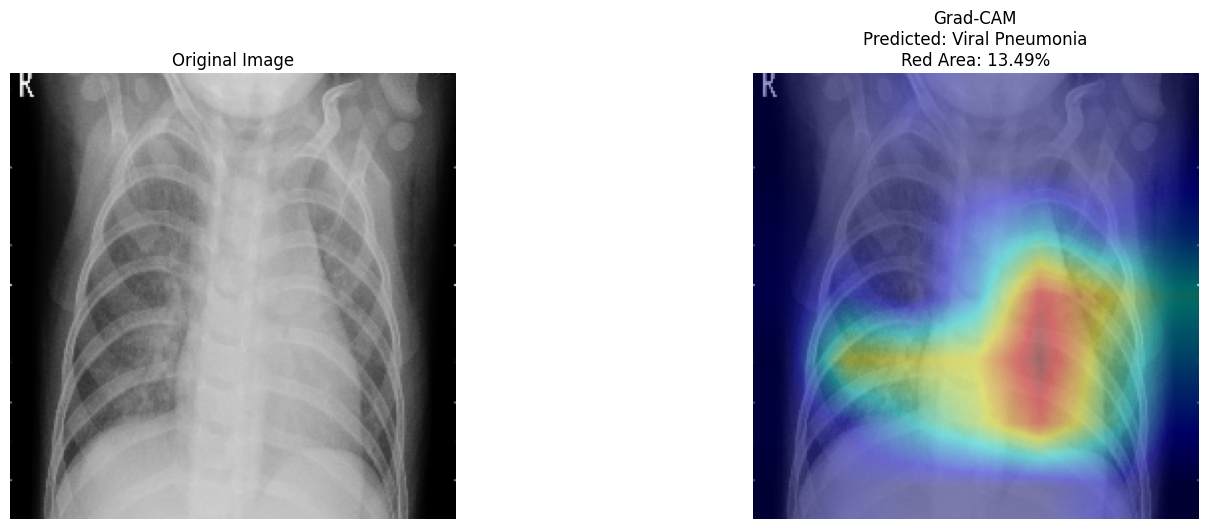

Detailed Report
----------------------------
Predicted Disease: Viral Pneumonia
Affected Area (%): 13.49
Severity Level: Moderate
Recommendation: Doctor consultation, antiviral medication, oxygen monitoring.
----------------------------


In [28]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S with a modified classifier
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your model's number of classes
)

# Load model weights
model_path = "/kaggle/input/modelv2/best_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")
model.to(device)
model.eval()

# --------------------------
# 2. Image Preprocessing
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image, image_tensor

# --------------------------
# 3. Compute Red Area Percentage
# --------------------------
def calculate_red_area_percentage(heatmap):
    red_mask = heatmap[:, :, 2] > 150  # Threshold for strong red activation
    red_percentage = np.sum(red_mask) / (heatmap.shape[0] * heatmap.shape[1]) * 100
    return red_percentage

# --------------------------
# 4. Severity Classification & Recommendations
# --------------------------
def classify_severity(percentage):
    if percentage < 10:
        return "Mild"
    elif 10 <= percentage < 30:
        return "Moderate"
    else:
        return "Severe"

def get_recommendation(pred_label, severity):
    recommendations = {
        "Bacterial Pneumonia": {
            "Mild": "Antibiotics, rest, hydration, avoid smoking.",
            "Moderate": "Doctor consultation, prescribed antibiotics, oxygen monitoring.",
            "Severe": "Hospitalization, IV antibiotics, oxygen therapy."
        },
        "Corona Virus Disease": {
            "Mild": "Home isolation, symptomatic treatment, hydration.",
            "Moderate": "Doctor consultation, antiviral medication, oxygen monitoring.",
            "Severe": "Hospitalization, oxygen support, ventilatory support if needed."
        },
        "Normal": {"General": "No medical intervention required. Maintain a healthy lifestyle."},
        "Tuberculosis": {
            "Mild": "Start anti-TB medication (DOTS), proper nutrition.",
            "Moderate": "Doctor consultation, strict adherence to TB medication.",
            "Severe": "Hospitalization, isolation, long-term TB treatment."
        },
        "Viral Pneumonia": {
            "Mild": "Symptomatic treatment, rest, hydration.",
            "Moderate": "Doctor consultation, antiviral medication, oxygen monitoring.",
            "Severe": "Hospitalization, antiviral treatment, respiratory support."
        }
    }
    
    return recommendations.get(pred_label, {}).get(severity, "Consult a healthcare professional.")

# --------------------------
# 5. Grad-CAM Explanation with Extra Visualizations
# --------------------------
def explain_gradcam(image_path):
    # Preprocess image
    image, image_tensor = preprocess_image(image_path)

    # Forward pass to get prediction
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()
    predicted_label = classes[predicted_class]

    # Hook activations and gradients
    gradients = None
    activations = None

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Use model.features[-1] as in your working example
    target_layer = model.features[-1]
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image_tensor)

    # Backward pass for the predicted class
    model.zero_grad()
    output[0, predicted_class].backward()

    # Ensure gradients are captured
    if gradients is None or activations is None:
        handle_forward.remove()
        handle_backward.remove()
        print("Grad-CAM failed: No gradients or activations captured.")
        return

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze(0)
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = activations.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)

    # Load original image using OpenCV
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Calculate severity
    red_percentage = calculate_red_area_percentage(heatmap_color)
    severity = classify_severity(red_percentage)
    recommendation = get_recommendation(predicted_label, severity)

    # Extra Visualizations
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nPredicted: {predicted_label}\nRed Area: {red_percentage:.2f}%")
    plt.axis("off")

 


    plt.tight_layout()
    plt.show()

    handle_forward.remove()
    handle_backward.remove()

    print("Detailed Report")
    print("----------------------------")
    print("Predicted Disease:", predicted_label)
    print("Affected Area (%):", f"{red_percentage:.2f}")
    print("Severity Level:", severity)
    print("Recommendation:", recommendation)
    print("----------------------------")

# --------------------------
# 6. Run Grad-CAM Explanation
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/newtest/person53_virus_107.jpeg"

print("Running Grad-CAM with Detailed Report and Extra Visualizations...")
explain_gradcam(image_path)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Running Grad-CAM with Detailed Report and Extra Visualizations...


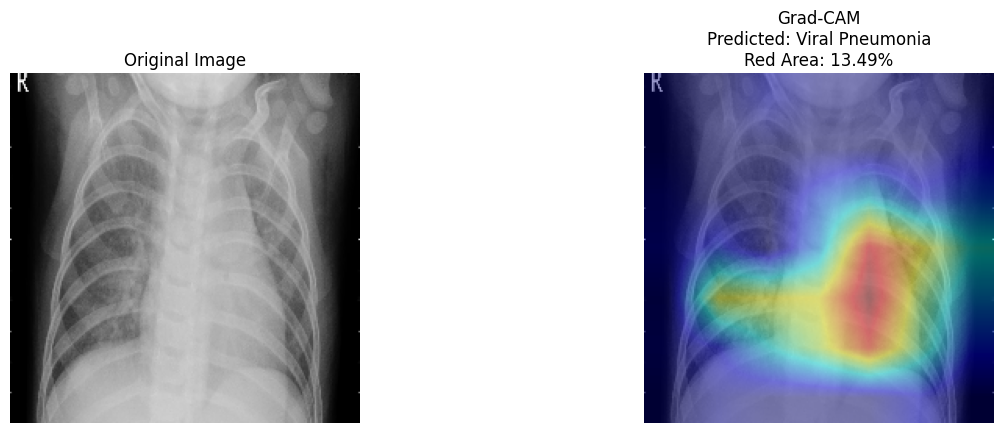

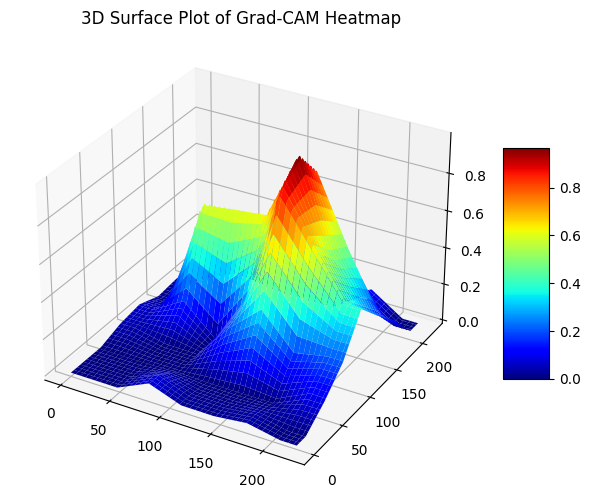

<Figure size 640x480 with 0 Axes>

Detailed Report
----------------------------
Predicted Disease: Viral Pneumonia
Affected Area (%): 13.49
Severity Level: Moderate
Recommendation: Doctor consultation, antiviral medication, oxygen monitoring.
----------------------------


In [41]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S with a modified classifier
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your model's number of classes
)

# Load model weights
model_path = "/kaggle/input/modelv2/best_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")
model.to(device)
model.eval()

# --------------------------
# 2. Image Preprocessing
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image, image_tensor

# --------------------------
# 3. Compute Red Area Percentage
# --------------------------
def calculate_red_area_percentage(heatmap):
    red_mask = heatmap[:, :, 2] > 150  # Threshold for strong red activation
    red_percentage = np.sum(red_mask) / (heatmap.shape[0] * heatmap.shape[1]) * 100
    return red_percentage

# --------------------------
# 4. Severity Classification & Recommendations
# --------------------------
def classify_severity(percentage):
    if percentage < 10:
        return "Mild"
    elif 10 <= percentage < 30:
        return "Moderate"
    else:
        return "Severe"

def get_recommendation(pred_label, severity):
    recommendations = {
        "Bacterial Pneumonia": {
            "Mild": "Antibiotics, rest, hydration, avoid smoking.",
            "Moderate": "Doctor consultation, prescribed antibiotics, oxygen monitoring.",
            "Severe": "Hospitalization, IV antibiotics, oxygen therapy."
        },
        "Corona Virus Disease": {
            "Mild": "Home isolation, symptomatic treatment, hydration.",
            "Moderate": "Doctor consultation, antiviral medication, oxygen monitoring.",
            "Severe": "Hospitalization, oxygen support, ventilatory support if needed."
        },
        "Normal": {"General": "No medical intervention required. Maintain a healthy lifestyle."},
        "Tuberculosis": {
            "Mild": "Start anti-TB medication (DOTS), proper nutrition.",
            "Moderate": "Doctor consultation, strict adherence to TB medication.",
            "Severe": "Hospitalization, isolation, long-term TB treatment."
        },
        "Viral Pneumonia": {
            "Mild": "Symptomatic treatment, rest, hydration.",
            "Moderate": "Doctor consultation, antiviral medication, oxygen monitoring.",
            "Severe": "Hospitalization, antiviral treatment, respiratory support."
        }
    }
    
    return recommendations.get(pred_label, {}).get(severity, "Consult a healthcare professional.")





# --------------------------
# 5. Grad-CAM Explanation with Extra Visualizations
# --------------------------
def explain_gradcam(image_path):
    # Preprocess image
    image, image_tensor = preprocess_image(image_path)

    # Forward pass to get prediction
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()
    predicted_label = classes[predicted_class]

    # Hook activations and gradients
    gradients = None
    activations = None

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Use model.features[-1] as in your working example
    target_layer = model.features[-1]
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image_tensor)

    # Backward pass for the predicted class
    model.zero_grad()
    output[0, predicted_class].backward()

    # Ensure gradients are captured
    if gradients is None or activations is None:
        handle_forward.remove()
        handle_backward.remove()
        print("Grad-CAM failed: No gradients or activations captured.")
        return

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.squeeze(0)
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = activations.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)

    # Load original image using OpenCV
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Calculate severity
    red_percentage = calculate_red_area_percentage(heatmap_color)
    severity = classify_severity(red_percentage)
    recommendation = get_recommendation(predicted_label, severity)

    # Extra Visualizations
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nPredicted: {predicted_label}\nRed Area: {red_percentage:.2f}%")
    plt.axis("off")

 
        # -------------------- 3D Surface Plot --------------------
    X = np.arange(heatmap_resized.shape[1])
    Y = np.arange(heatmap_resized.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = heatmap_resized  # Use the resized heatmap for 3D plot

    fig3d = plt.figure(figsize=(8, 6))
    ax3d = fig3d.add_subplot(111, projection='3d')
    surf = ax3d.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')
    ax3d.set_title("3D Surface Plot of Grad-CAM Heatmap")
    fig3d.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


    plt.tight_layout()
    plt.show()

    handle_forward.remove()
    handle_backward.remove()

    print("Detailed Report")
    print("----------------------------")
    print("Predicted Disease:", predicted_label)
    print("Affected Area (%):", f"{red_percentage:.2f}")
    print("Severity Level:", severity)
    print("Recommendation:", recommendation)
    print("----------------------------")

# --------------------------
# 6. Run Grad-CAM Explanation
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/newtest/person53_virus_107.jpeg"

print("Running Grad-CAM with Detailed Report and Extra Visualizations...")
explain_gradcam(image_path)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Running LIME Explanation with Detailed Report, Extra Visualizations, and 3D Surface Plot...


  0%|          | 0/1000 [00:00<?, ?it/s]

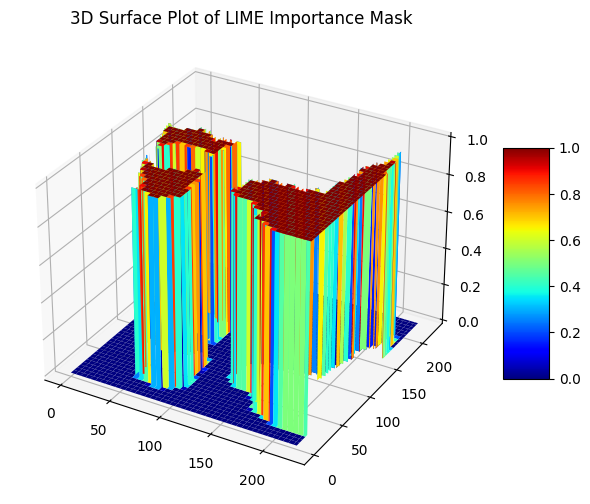

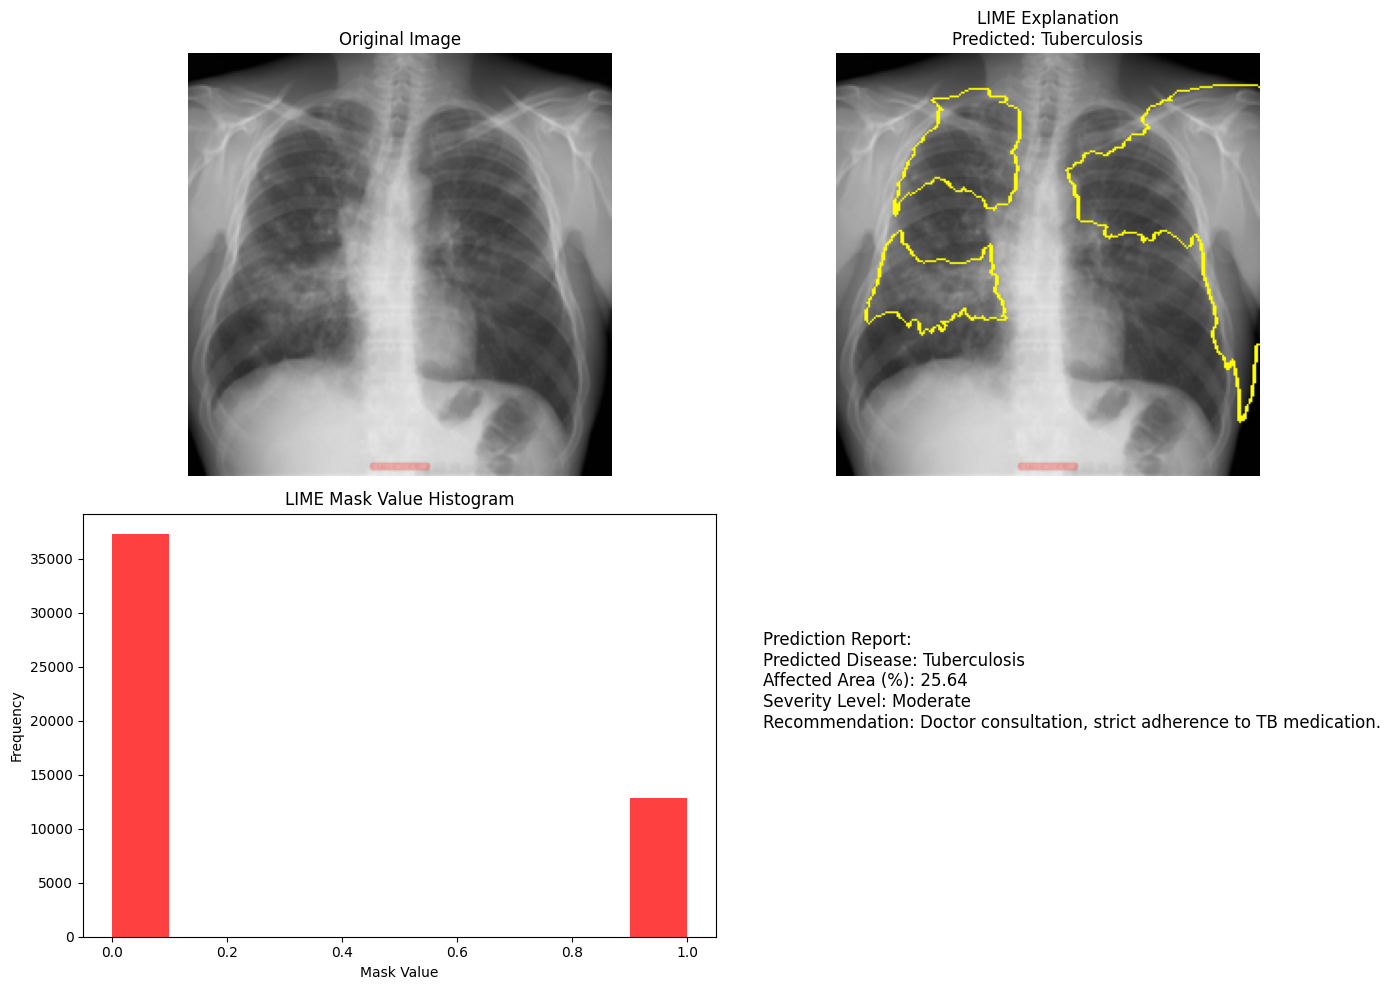

Detailed Report
----------------------------
Predicted Disease: Tuberculosis
Affected Area (%): 25.64
Severity Level: Moderate
Recommendation: Doctor consultation, strict adherence to TB medication.
----------------------------
Predicted Class: Tuberculosis


In [42]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_v2_s
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
from PIL import Image
import os
from lime import lime_image
from skimage.segmentation import mark_boundaries

# --------------------------
# 1. Device & Model Loading
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-V2-S with a modified classifier
model = efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 5)  # Ensure this matches your model's number of classes
)

model_path = "/kaggle/input/modelv2/best_model.pth"  # Update with your path
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError(f"Model file '{model_path}' not found!")
model.to(device)
model.eval()

# Define class labels
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]

# --------------------------
# 2. Image Preprocessing
# --------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file '{image_path}' not found!")
    return Image.open(image_path).convert("RGB")

def preprocess_for_model(image):
    return preprocess(image).unsqueeze(0).to(device)

# --------------------------
# 3. Predict Probability Function for LIME
# --------------------------
def predict_proba(images):
    """
    Takes a list of images (numpy arrays with pixel range [0, 255])
    converts them to PIL images, applies preprocessing,
    and returns the model's softmax probabilities.
    """
    tensors = []
    for img in images:
        # Convert array to PIL image and then to tensor
        pil_img = Image.fromarray(img.astype(np.uint8))
        tensor = preprocess(pil_img)
        tensors.append(tensor)
    input_tensor = torch.stack(tensors).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

# --------------------------
# 4. Helper Functions for Severity & Recommendations
# --------------------------
def classify_severity(percentage):
    if percentage < 10:
        return "Mild"
    elif 10 <= percentage < 30:
        return "Moderate"
    else:
        return "Severe"

def get_recommendation(pred_label, severity):
    recommendations = {
        "Bacterial Pneumonia": {
            "Mild": "Antibiotics, rest, hydration, avoid smoking.",
            "Moderate": "Doctor consultation, prescribed antibiotics, oxygen monitoring.",
            "Severe": "Hospitalization, IV antibiotics, oxygen therapy."
        },
        "Corona Virus Disease": {
            "Mild": "Home isolation, symptomatic treatment, hydration.",
            "Moderate": "Doctor consultation, antiviral medication, oxygen monitoring.",
            "Severe": "Hospitalization, oxygen support, ventilatory support if needed."
        },
        "Normal": {"General": "No medical intervention required. Maintain a healthy lifestyle."},
        "Tuberculosis": {
            "Mild": "Start anti-TB medication (DOTS), proper nutrition.",
            "Moderate": "Doctor consultation, strict adherence to TB medication.",
            "Severe": "Hospitalization, isolation, long-term TB treatment."
        },
        "Viral Pneumonia": {
            "Mild": "Symptomatic treatment, rest, hydration.",
            "Moderate": "Doctor consultation, antiviral medication, oxygen monitoring.",
            "Severe": "Hospitalization, antiviral treatment, respiratory support."
        }
    }
    if pred_label == "Normal":
        return recommendations["Normal"]["General"]
    return recommendations.get(pred_label, {}).get(severity, "Consult a healthcare professional.")

def calculate_affected_area(mask):
    """
    Calculate the percentage of pixels marked as important by LIME.
    Here, we assume mask is a binary mask with nonzero indicating importance.
    """
    important = np.sum(mask != 0)
    total = mask.size
    return (important / total) * 100

# --------------------------
# 5. LIME Explanation with Extra Visualizations and Detailed Report
# --------------------------
def explain_lime(image_path, num_samples=1000):
    # Load and preprocess image for model inference
    image = load_image(image_path)
    image_resized = image.resize((224, 224))
    image_np = np.array(image_resized)
    
    # Create a LimeImageExplainer
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image_np, 
                                             predict_proba, 
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=num_samples)
    
    # Get predicted class from model
    probs = predict_proba([image_np])
    predicted_class = np.argmax(probs[0])
    predicted_label = classes[predicted_class]
    
    # Get explanation mask for the predicted class (only positive contributions)
    temp, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, hide_rest=False)
    
    # For visualization: mark boundaries on the image
    lime_image_boundaries = mark_boundaries(temp.astype(np.uint8), mask)
    
    # Compute affected area from the mask
    affected_area = calculate_affected_area(mask)
    severity = classify_severity(affected_area)
    recommendation = get_recommendation(predicted_label, severity)
    
    # 3D Surface Plot of the LIME mask
    # Convert mask to float (0 or 1) and resize to (224,224)
    mask_float = (mask > 0).astype(np.float32)
    X = np.arange(mask_float.shape[1])
    Y = np.arange(mask_float.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = mask_float  # This is binary; for 3D, it will look like a plateau

    fig3d = plt.figure(figsize=(8,6))
    ax3d = fig3d.add_subplot(111, projection='3d')
    surf = ax3d.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')
    ax3d.set_title("3D Surface Plot of LIME Importance Mask")
    fig3d.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
    # Extra Visualizations in 2D
    plt.figure(figsize=(15,10))
    
    # Subplot 1: Original Image
    plt.subplot(2,2,1)
    plt.imshow(image_resized)
    plt.title("Original Image")
    plt.axis("off")
    
    # Subplot 2: LIME Explanation (with boundaries)
    plt.subplot(2,2,2)
    plt.imshow(lime_image_boundaries)
    plt.title(f"LIME Explanation\nPredicted: {predicted_label}")
    plt.axis("off")
    
    # Subplot 3: Histogram of LIME mask values
    plt.subplot(2,2,3)
    plt.hist(mask.ravel(), bins=10, color='r', alpha=0.75)
    plt.title("LIME Mask Value Histogram")
    plt.xlabel("Mask Value")
    plt.ylabel("Frequency")
    
    # Subplot 4: Detailed Report
    plt.subplot(2,2,4)
    plt.axis("off")
    report_text = f"""Prediction Report:
Predicted Disease: {predicted_label}
Affected Area (%): {affected_area:.2f}
Severity Level: {severity}
Recommendation: {recommendation}"""
    plt.text(0.05, 0.5, report_text, fontsize=12, wrap=True)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed report
    print("Detailed Report")
    print("----------------------------")
    print("Predicted Disease:", predicted_label)
    print("Affected Area (%):", f"{affected_area:.2f}")
    print("Severity Level:", severity)
    print("Recommendation:", recommendation)
    print("----------------------------")
    
    return predicted_label

# --------------------------
# 6. Run LIME Explanation
# --------------------------
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
image_path = "/kaggle/input/testing/Tuberculosis-205.jpg"  # Update with your image path

print("Running LIME Explanation with Detailed Report, Extra Visualizations, and 3D Surface Plot...")
predicted_label = explain_lime(image_path)
print("Predicted Class:", predicted_label)
